In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from skimage.feature import hog
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray
from scipy.spatial.distance import cdist
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import color, exposure
from skimage.io import imread
from skimage.transform import resize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import ViTForImageClassification, ViTImageProcessor
import requests
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms.functional as F
from collections import Counter
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1- Charging and exploring the data

In [19]:
dataset_path = "chest_xray"

# Define the subdirectories for train, test, and validation
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

In [20]:
COUNT_NORMAL = {"train": 0, "test": 0, "val": 0}
COUNT_PNEUMONIA = {"train": 0, "test": 0, "val": 0}

def load_and_preprocess_images(folder_path, label, split):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize the image
            img = np.array(img) / 255.0  # Normalize between 0 and 1
            images.append(img)
            labels.append(label)
            
            # Update counts
            if label == 0:  # NORMAL
                COUNT_NORMAL[split] += 1
            else:  # PNEUMONIA
                COUNT_PNEUMONIA[split] += 1
                
        except Exception as e:
            print(f"Corrupted image: {file_path}, error: {e}")
    return images, labels

In [21]:
data = {"train": [], "test": [], "val": []}
labels = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, lbls = load_and_preprocess_images(folder_path, category_label, subdir)
        data[subdir].extend(images)
        labels[subdir].extend(lbls)

# Conversion en numpy arrays et ajout de la dimension canal (pour CNN)
for key in data:
    data[key] = np.expand_dims(np.array(data[key]), axis=-1)  
    labels[key] = np.array(labels[key])


In [22]:
print(f"COUNT_NORMAL in train: {COUNT_NORMAL['train']}")
print(f"COUNT_PNEUMONIA in train: {COUNT_PNEUMONIA['train']}")
print(f"COUNT_NORMAL in test: {COUNT_NORMAL['test']}")
print(f"COUNT_PNEUMONIA in test: {COUNT_PNEUMONIA['test']}")
print(f"COUNT_NORMAL in val: {COUNT_NORMAL['val']}")
print(f"COUNT_PNEUMONIA in val: {COUNT_PNEUMONIA['val']}")

COUNT_NORMAL in train: 1341
COUNT_PNEUMONIA in train: 3875
COUNT_NORMAL in test: 234
COUNT_PNEUMONIA in test: 390
COUNT_NORMAL in val: 8
COUNT_PNEUMONIA in val: 8


In [7]:
data["train"] = np.array(data["train"])
labels["train"] = np.array(labels["train"])
data["test"] = np.array(data["test"])
labels["test"] = np.array(labels["test"])
data["val"] = np.array(data["val"])
labels["val"] = np.array(labels["val"])

print("Data loaded successfully!")
print(f"Train data shape: {data['train'].shape}, Train labels shape: {labels['train'].shape}")
print(f"Test data shape: {data['test'].shape}, Test labels shape: {labels['test'].shape}")
print(f"Validation data shape: {data['val'].shape}, Validation labels shape: {labels['val'].shape}")

Data loaded successfully!
Train data shape: (5216, 128, 128, 1), Train labels shape: (5216,)
Test data shape: (624, 128, 128, 1), Test labels shape: (624,)
Validation data shape: (16, 128, 128, 1), Validation labels shape: (16,)


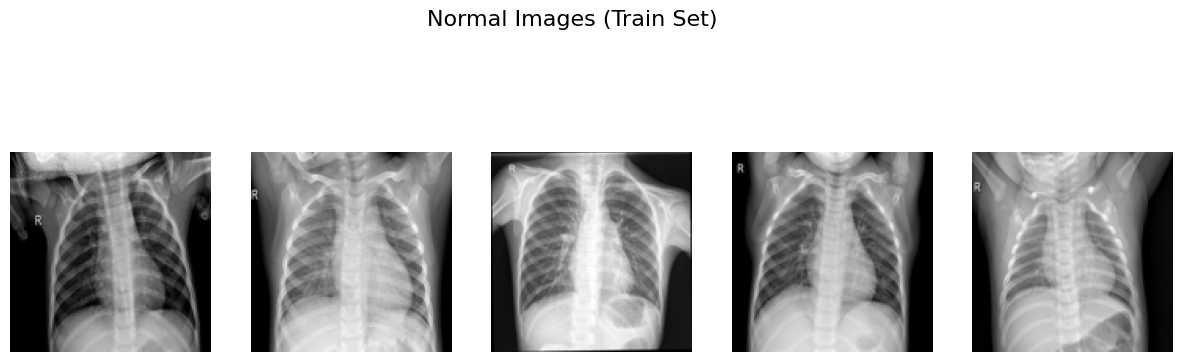

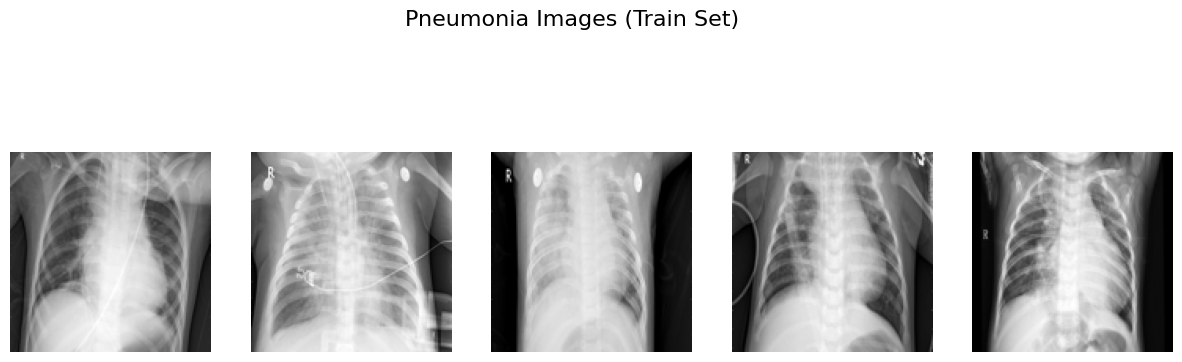

In [8]:
# Function to plot images
def plot_images(data, labels, category_label, title, n=5):

    # Filter the images for the specified category (NORMAL or PNEUMONIA)
    category_images = [data[i] for i in range(len(labels)) if labels[i] == category_label]
    
    # Select random images
    selected_indices = [randint(0, len(category_images) - 1) for _ in range(n)]
    selected_images = [category_images[i] for i in selected_indices]
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(selected_images):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Plot NORMAL images
plot_images(data["train"], labels["train"], category_label=0, title="Normal Images (Train Set)", n=5)

# Plot PNEUMONIA images
plot_images(data["train"], labels["train"], category_label=1, title="Pneumonia Images (Train Set)", n=5)


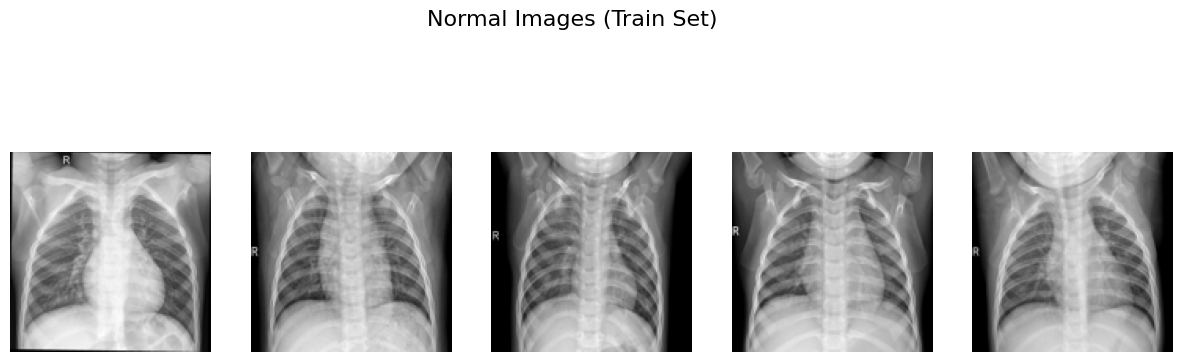

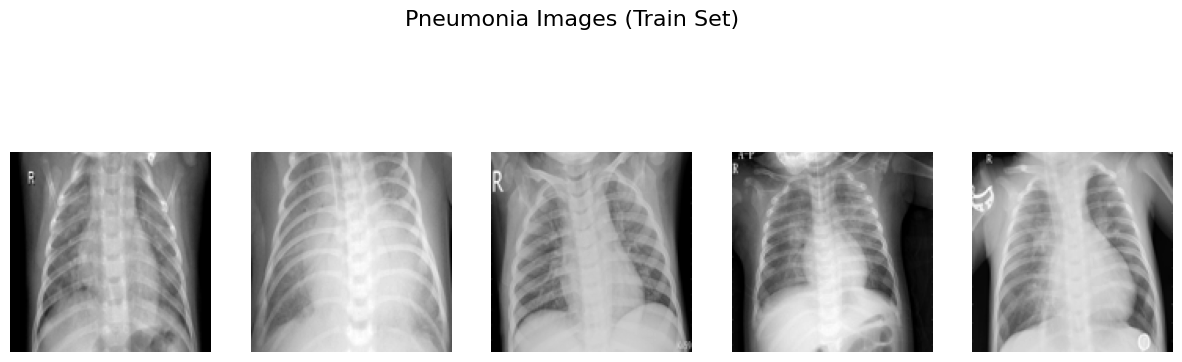

In [9]:
def plot_images(data, labels, category_label, title, n=5):
    category_images = [data[i] for i in range(len(labels)) if labels[i] == category_label]
    selected_images = [category_images[i] for i in np.random.choice(len(category_images), n, replace=False)]
    
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(selected_images):
        plt.subplot(1, n, i + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Afficher des images de chaque catégorie
plot_images(data["train"], labels["train"], category_label=0, title="Normal Images (Train Set)")
plot_images(data["train"], labels["train"], category_label=1, title="Pneumonia Images (Train Set)")


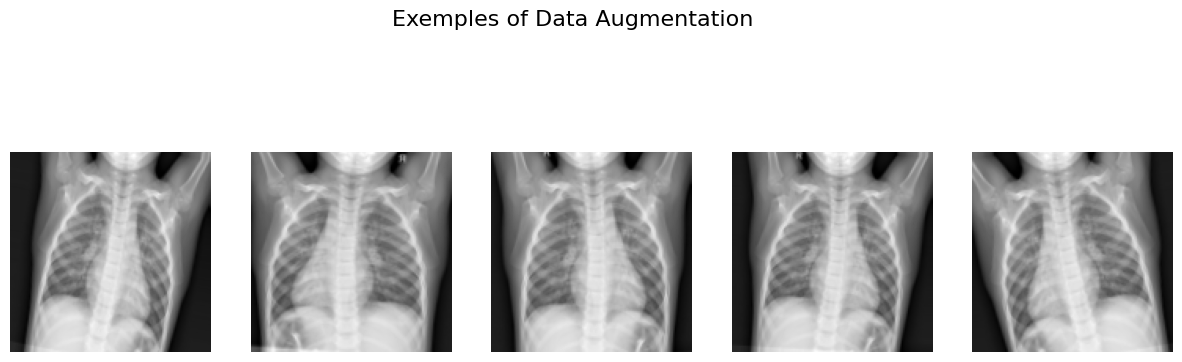

In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range=0.1,  
    horizontal_flip=True  
)

# Exemple d’augmentation d’une image
sample_img = np.expand_dims(data["train"][0], axis=0)  
augmented_images = [datagen.flow(sample_img, batch_size=1)[0].squeeze() for _ in range(5)]

# Affichage des images augmentées
plt.figure(figsize=(15, 5))
for i, img in enumerate(augmented_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.suptitle("Exemples of Data Augmentation", fontsize=16)
plt.show()


# Comparaison des Performances des Modèles pour Chaque Descripteur et Analyse des Résultats entre les Descripteurs

# 1-HOG (Histogram of gradients)

### Pourquoi HOG : 
- Capture des formes et textures : HOG extrait efficacement les contours et anomalies pulmonaires.

- Invariance à l’éclairage : Il est robuste aux variations de luminosité des radiographies.

- Détection des anomalies : Il met en évidence les opacités causées par la pneumonie.

- Adapté aux modèles ML : Compatible avec KNN, Nb et CNNs.

- Efficace et rapide : Faible coût computationnel par rapport aux CNNs.

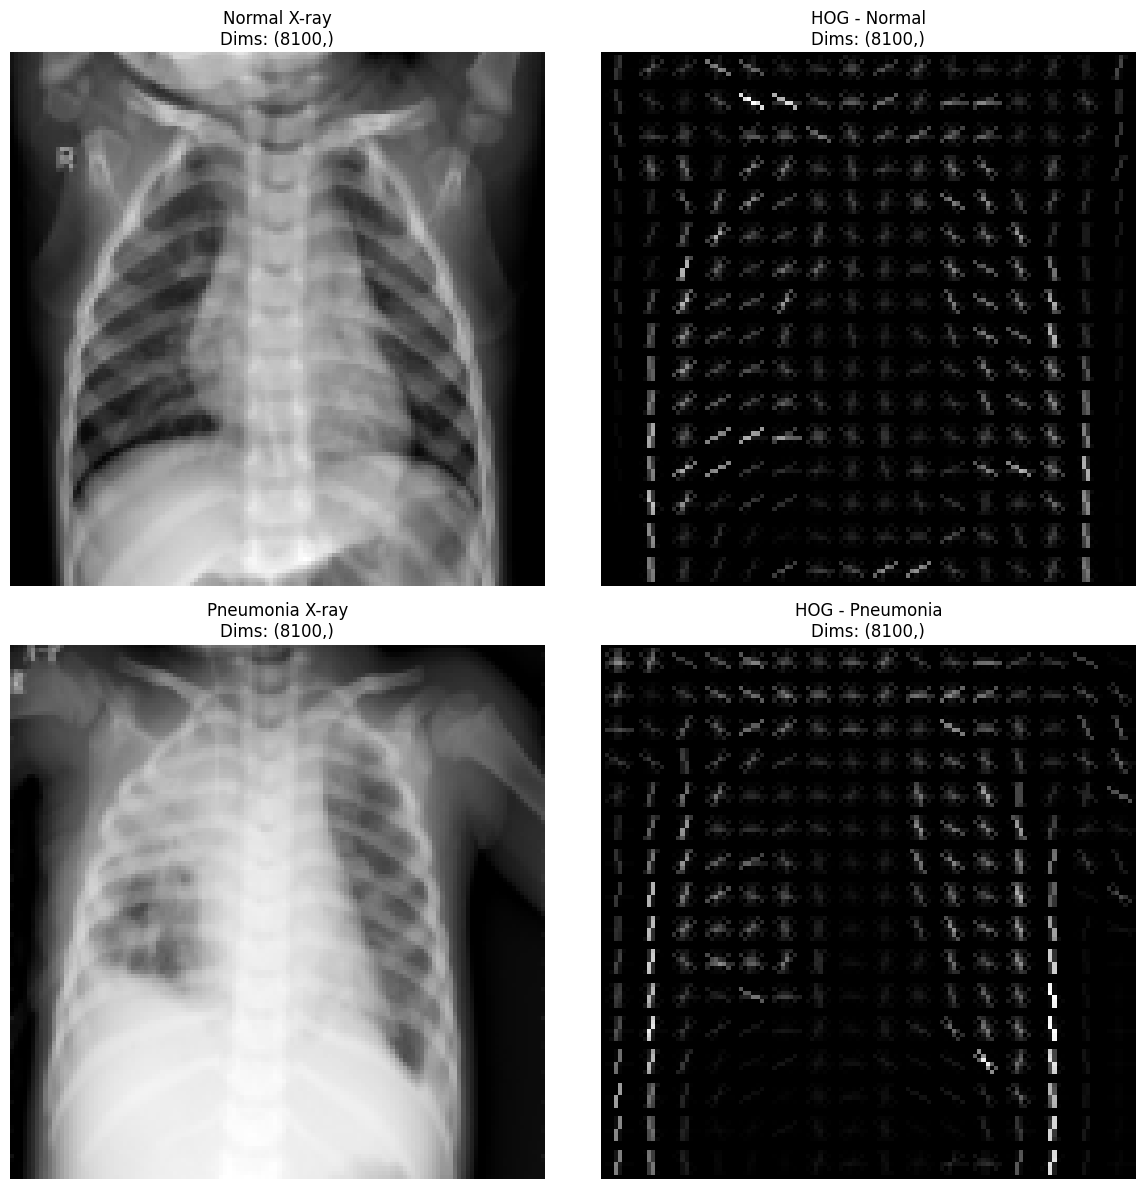

In [23]:

def extract_hog_features(image_path):
    """Extracts and visualizes HOG features from an image."""
    image = imread(image_path)
    if len(image.shape) == 3:  # Convert to grayscale if RGB
        image = rgb2gray(image)
    image_resized = resize(image, (128, 128))
    
    feature_vector, hog_image = hog(
        image_resized,
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True, 
        feature_vector=True
    )
    
    return image_resized, hog_image, feature_vector

# Paths to images
normal_image_path = "chest_xray/train/NORMAL/IM-0117-0001.jpeg"
pneumonia_image_path = "chest_xray/train/PNEUMONIA/person1934_bacteria_4846.jpeg"

# Extract HOG features
normal_image, normal_hog, normal_feature_vector = extract_hog_features(normal_image_path)
pneumonia_image, pneumonia_hog, pneumonia_feature_vector = extract_hog_features(pneumonia_image_path)

# Get the dimensions of the feature vectors
normal_feature_dims = normal_feature_vector.shape
pneumonia_feature_dims = pneumonia_feature_vector.shape

# Plot the original and HOG images for both cases
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(normal_image, cmap='gray')
axes[0, 0].set_title(f"Normal X-ray\nDims: {normal_feature_dims}")
axes[0, 0].axis('off')

axes[0, 1].imshow(normal_hog, cmap='gray')
axes[0, 1].set_title(f"HOG - Normal\nDims: {normal_feature_dims}")
axes[0, 1].axis('off')

axes[1, 0].imshow(pneumonia_image, cmap='gray')
axes[1, 0].set_title(f"Pneumonia X-ray\nDims: {pneumonia_feature_dims}")
axes[1, 0].axis('off')

axes[1, 1].imshow(pneumonia_hog, cmap='gray')
axes[1, 1].set_title(f"HOG - Pneumonia\nDims: {pneumonia_feature_dims}")
axes[1, 1].axis('off')

plt.tight_layout()

# Save the plot to a file
plt.savefig("hog_features_plot.png")

# Display the plot
plt.show()


## Analyse des résultats : 

- Densité des gradients : Plus homogène et régulière dans l’image normale, plus dispersée dans l’image avec pneumonie.
- Contraste des bords : Les contours sont nets et symétriques dans l’image normale, tandis que l’image avec pneumonie montre des perturbations et des irrégularités.
- Zones de forte intensité : Répartition équilibrée des gradients en cas normal, alors que des zones de forte intensité apparaissent dans l’image avec pneumonie, correspondant aux infiltrats pulmonaires.

extraction des caractéristiques hog pour toutes les images 

In [52]:
from skimage.feature import hog
from skimage.transform import resize
import numpy as np

# Fonction pour extraire les caractéristiques HOG d'une image
def extract_hog_features(image):
    """Extrait les caractéristiques HOG d'une image."""
    image_resized = resize(image, (128, 128))  # Redimensionnement
    feature_vector = hog(
        image_resized,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False, 
        feature_vector=True
    )
    return feature_vector

# Extraction des caractéristiques HOG pour chaque ensemble de données
X_train_hog = np.array([extract_hog_features(img) for img in data["train"]])
X_test_hog = np.array([extract_hog_features(img) for img in data["test"]])
X_val_hog = np.array([extract_hog_features(img) for img in data["val"]])

# Labels associés (déjà chargés)
y_train = labels["train"]
y_test = labels["test"]
y_val = labels["val"]

# Affichage des dimensions finales
print("\n=== Dimensions des caractéristiques HOG ===")
print(f"Train - X: {X_train_hog.shape}, y: {y_train.shape}")
print(f"Test - X: {X_test_hog.shape}, y: {y_test.shape}")
print(f"Val - X: {X_val_hog.shape}, y: {y_val.shape}")



=== Dimensions des caractéristiques HOG ===
Train - X: (5216, 8100), y: (5216,)
Test - X: (624, 8100), y: (624,)
Val - X: (16, 8100), y: (16,)


## Réduction de la dimension en utilisant PCA

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Réduction à 1000 dimensions avec PCA
n_components = 1500

# Standardisation des données (important pour PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)
X_val_scaled = scaler.transform(X_val_hog)

# Application de PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Affichage des nouvelles dimensions
print("\n=== Dimensions après PCA ===")
print(f"Train - X: {X_train_pca.shape}, y: {y_train.shape}")
print(f"Test - X: {X_test_pca.shape}, y: {y_test.shape}")
print(f"Val - X: {X_val_pca.shape}, y: {y_val.shape}")



=== Dimensions après PCA ===
Train - X: (5216, 1500), y: (5216,)
Test - X: (624, 1500), y: (624,)
Val - X: (16, 1500), y: (16,)


Variance expliquée totale par 1500 composantes : 93.91%


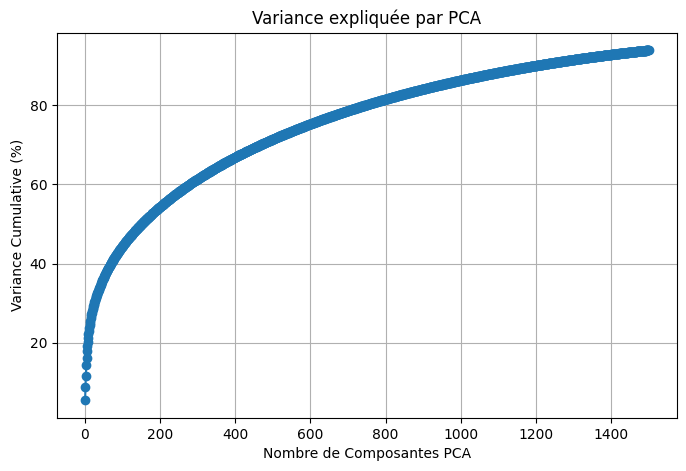

In [57]:
import matplotlib.pyplot as plt

# Afficher le pourcentage de variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)  # Somme cumulée

# Affichage du total de variance expliquée
print(f"Variance expliquée totale par {n_components} composantes : {cumulative_variance[-1]*100:.2f}%")

# Tracer la variance expliquée
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, n_components + 1), cumulative_variance * 100, marker='o', linestyle='-')
plt.xlabel("Nombre de Composantes PCA")
plt.ylabel("Variance Cumulative (%)")
plt.title("Variance expliquée par PCA")
plt.grid(True)
plt.show()


## Tester le KNN avec les meilleurs paramètres et K-folds pour la détermination du K

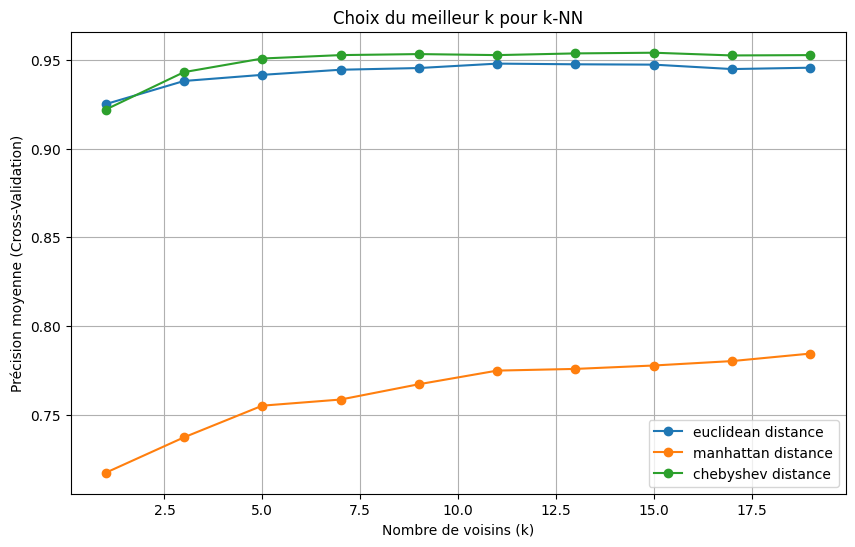

Meilleur modèle : k = 15, Distance = chebyshev, Précision moyenne = 95.40%


In [125]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Stocker les scores pour chaque k
k_scores = {}
best_k = None
best_metric = None
best_score = 0
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev"]
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds

for metric in distance_metrics:
    scores_per_k = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X_train_pca, y_train, cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        scores_per_k.append(mean_score)
        
        # Vérification du meilleur modèle
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric
    
    k_scores[metric] = scores_per_k

# Tracer la courbe
plt.figure(figsize=(10, 6))
for metric, scores in k_scores.items():
    plt.plot(k_values, scores, marker='o', linestyle='-', label=f'{metric} distance')

plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Précision moyenne (Cross-Validation)")
plt.title("Choix du meilleur k pour k-NN")
plt.legend()
plt.grid(True)
plt.show()

# Affichage du meilleur modèle
print(f"Meilleur modèle : k = {best_k}, Distance = {best_metric}, Précision moyenne = {best_score * 100:.2f}%")


## knn avec dimension reduite (PCA)

Accuracy sur l'ensemble de test : 73.40%

Classification Report :
              precision    recall  f1-score   support

      Normal       0.88      0.34      0.49       234
   Pneumonia       0.71      0.97      0.82       390

    accuracy                           0.73       624
   macro avg       0.79      0.65      0.65       624
weighted avg       0.77      0.73      0.70       624



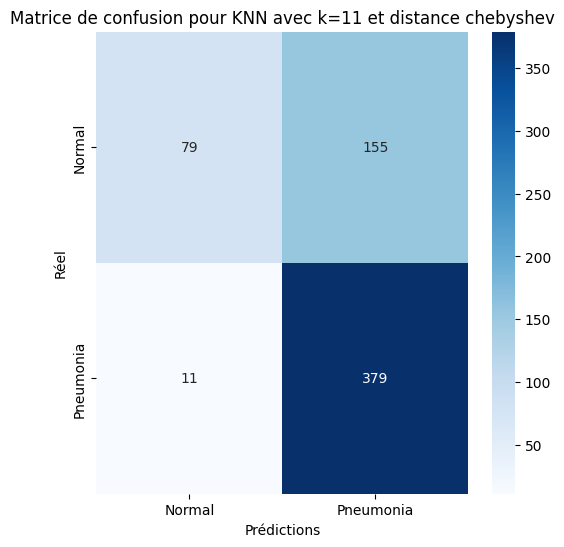

In [150]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Initialiser le modèle KNN avec les meilleurs paramètres
knn_best = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)

# Entraînement sur l'ensemble d'entraînement
knn_best.fit(X_train_pca, y_train)

# Prédictions sur l'ensemble de test
y_pred_test = knn_best.predict(X_test_pca)

# Calcul de l'accuracy sur l'ensemble de test
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy sur l'ensemble de test : {test_accuracy * 100:.2f}%")

# Affichage du Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_test, target_names=["Normal", "Pneumonia"]))


# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title(f"Matrice de confusion pour KNN avec k={best_k} et distance {best_metric}")
plt.show()


## Naive Bayes avec PCA

Accuracy sur l'ensemble de test : 55.45%

Classification Report :
              precision    recall  f1-score   support

      Normal       0.45      0.87      0.59       234
   Pneumonia       0.82      0.37      0.51       390

    accuracy                           0.55       624
   macro avg       0.64      0.62      0.55       624
weighted avg       0.68      0.55      0.54       624



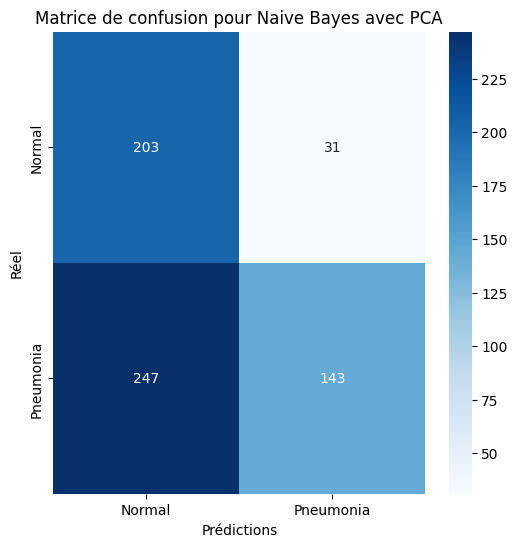

In [149]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialiser le modèle Naive Bayes
nb_model = GaussianNB()

# Entraîner le modèle Naive Bayes sur l'ensemble d'entraînement
nb_model.fit(X_train_pca, y_train)

# Prédictions sur l'ensemble de test
y_pred_test = nb_model.predict(X_test_pca)

# Calcul de l'accuracy sur l'ensemble de test
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy sur l'ensemble de test : {test_accuracy * 100:.2f}%")

# Affichage du Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_test, target_names=["Normal", "Pneumonia"]))

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion pour Naive Bayes avec PCA")
plt.show()


## svm avec PCA

Accuracy sur l'ensemble de test (SVM) : 76.12%
Classification Report :
              precision    recall  f1-score   support

      Normal       0.98      0.37      0.54       234
   Pneumonia       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.69       624
weighted avg       0.82      0.76      0.73       624



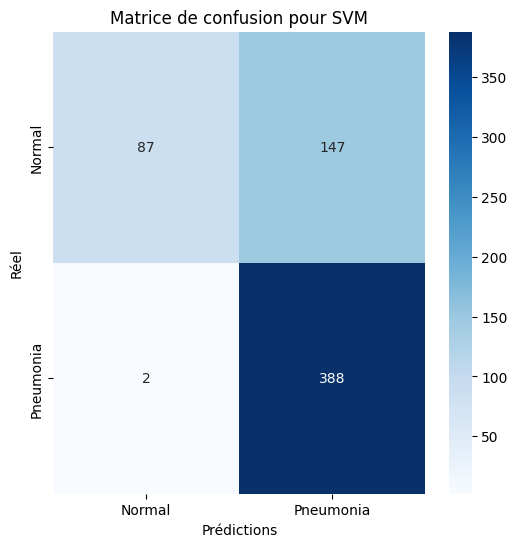

In [130]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Initialisation du modèle SVM avec un noyau linéaire
svm_model = SVC(kernel='linear', random_state=42)

# Entraînement du modèle SVM
svm_model.fit(X_train_pca, y_train)

# Prédictions sur l'ensemble de test
y_pred_test_svm = svm_model.predict(X_test_pca)

# Calcul de l'accuracy
test_accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
print(f"Accuracy sur l'ensemble de test (SVM) : {test_accuracy_svm * 100:.2f}%")

# Affichage du classification report
print("Classification Report :")
print(classification_report(y_test, y_pred_test_svm, target_names=["Normal", "Pneumonia"]))

# Matrice de confusion
conf_matrix_svm = confusion_matrix(y_test, y_pred_test_svm)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion pour SVM")
plt.show()

# Affichage du classification report en graphique (bar chart)
report = classification_report(y_test, y_pred_test_svm, output_dict=True)


## Oversampling pour réduire les non-détection 

Distribution des classes après SMOTE :
Classe 0 (Normal) : 3875
Classe 1 (Pneumonia) : 3875
Accuracy sur l'ensemble de test après SMOTE : 80.93%

Classification Report :
              precision    recall  f1-score   support

      Normal       0.81      0.64      0.72       234
   Pneumonia       0.81      0.91      0.86       390

    accuracy                           0.81       624
   macro avg       0.81      0.78      0.79       624
weighted avg       0.81      0.81      0.80       624



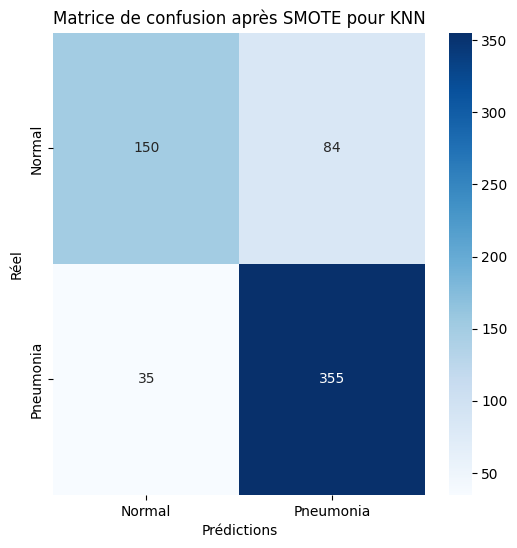

In [148]:
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' signifie qu'on équilibre avec la classe majoritaire
X_train_res, y_train_res = smote.fit_resample(X_train_pca, y_train)

# Vérification de l'équilibre des classes après SMOTE
print(f"Distribution des classes après SMOTE :")
print(f"Classe 0 (Normal) : {np.sum(y_train_res == 0)}")
print(f"Classe 1 (Pneumonia) : {np.sum(y_train_res == 1)}")

# Entraîner le modèle KNN avec les données équilibrées
knn_best_res = KNeighborsClassifier(n_neighbors=7, metric='chebyshev')
knn_best_res.fit(X_train_res, y_train_res)

# Prédictions sur l'ensemble de test
y_pred_test_res = knn_best_res.predict(X_test_pca)

# Calcul de l'accuracy sur l'ensemble de test
test_accuracy_res = accuracy_score(y_test, y_pred_test_res)
print(f"Accuracy sur l'ensemble de test après SMOTE : {test_accuracy_res * 100:.2f}%")

# Affichage du Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_test_res, target_names=["Normal", "Pneumonia"]))

# Calcul de la matrice de confusion
conf_matrix_res = confusion_matrix(y_test, y_pred_test_res)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_res, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion après SMOTE pour KNN")
plt.show()


Distribution des classes après SMOTE :
Classe 0 (Normal) : 3875
Classe 1 (Pneumonia) : 3875
Accuracy sur l'ensemble de test après SMOTE (SVM) : 76.12%

Classification Report :
              precision    recall  f1-score   support

      Normal       0.98      0.37      0.54       234
   Pneumonia       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.69       624
weighted avg       0.82      0.76      0.73       624



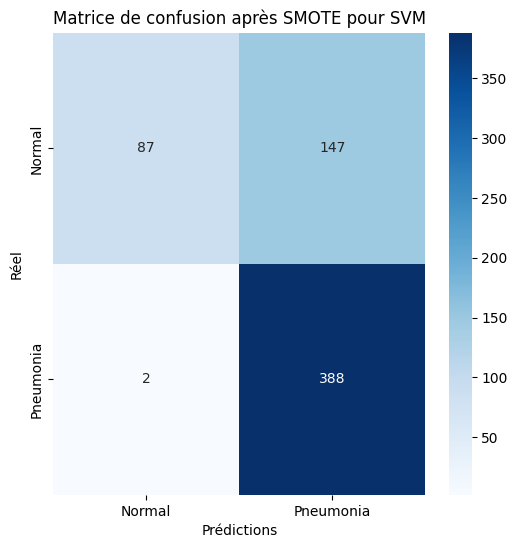

In [138]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Vérification de l'équilibre des classes après SMOTE
print(f"Distribution des classes après SMOTE :")
print(f"Classe 0 (Normal) : {np.sum(y_train_res == 0)}")
print(f"Classe 1 (Pneumonia) : {np.sum(y_train_res == 1)}")

# Initialisation du modèle SVM avec un noyau linéaire
svm_model = SVC(kernel='linear', random_state=42)

# Entraîner le modèle SVM avec les données rééquilibrées
svm_model.fit(X_train_res, y_train_res)

# Prédictions sur l'ensemble de test
y_pred_test_svm = svm_model.predict(X_test_pca)

# Calcul de l'accuracy sur l'ensemble de test
test_accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
print(f"Accuracy sur l'ensemble de test après SMOTE (SVM) : {test_accuracy_svm * 100:.2f}%")

# Affichage du classification report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_test_svm, target_names=["Normal", "Pneumonia"]))

# Calcul de la matrice de confusion
conf_matrix_svm = confusion_matrix(y_test, y_pred_test_svm)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion après SMOTE pour SVM")
plt.show()


## NB

Distribution des classes après SMOTE :
Classe 0 (Normal) : 3875
Classe 1 (Pneumonia) : 3875
Accuracy sur l'ensemble de test après SMOTE : 65.38%

Classification Report :
              precision    recall  f1-score   support

      Normal       0.54      0.48      0.51       234
   Pneumonia       0.71      0.76      0.73       390

    accuracy                           0.65       624
   macro avg       0.63      0.62      0.62       624
weighted avg       0.65      0.65      0.65       624



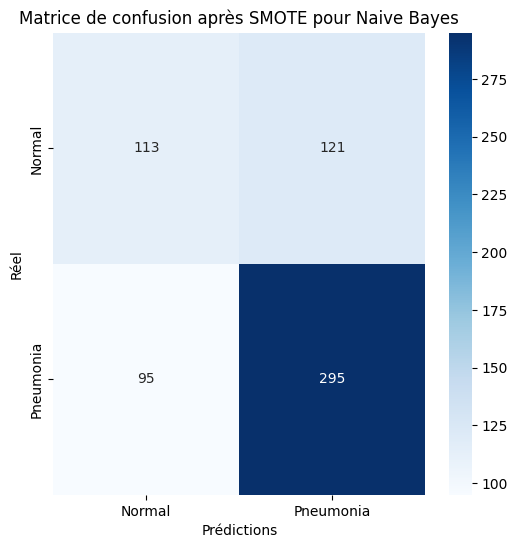

In [147]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' signifie qu'on équilibre avec la classe majoritaire
X_train_res, y_train_res = smote.fit_resample(X_train_pca, y_train)

# Vérification de l'équilibre des classes après SMOTE
print(f"Distribution des classes après SMOTE :")
print(f"Classe 0 (Normal) : {np.sum(y_train_res == 0)}")
print(f"Classe 1 (Pneumonia) : {np.sum(y_train_res == 1)}")

# Initialiser le modèle Naive Bayes
nb_model_res = GaussianNB()

# Entraîner le modèle Naive Bayes avec les données équilibrées
nb_model_res.fit(X_train_res, y_train_res)

# Prédictions sur l'ensemble de test
y_pred_test_res = nb_model_res.predict(X_test_pca)

# Calcul de l'accuracy sur l'ensemble de test
test_accuracy_res = accuracy_score(y_test, y_pred_test_res)
print(f"Accuracy sur l'ensemble de test après SMOTE : {test_accuracy_res * 100:.2f}%")

# Affichage du Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_test_res, target_names=["Normal", "Pneumonia"]))

# Calcul de la matrice de confusion
conf_matrix_res = confusion_matrix(y_test, y_pred_test_res)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_res, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion après SMOTE pour Naive Bayes")
plt.show()


## Undersampling pour équilibrer le jeu de données

Distribution des classes après Undersampling :
Classe 0 (Normal) : 1341
Classe 1 (Pneumonia) : 1341
Accuracy sur l'ensemble de test après Undersampling : 80.13%

Classification Report :
              precision    recall  f1-score   support

      Normal       0.82      0.60      0.69       234
   Pneumonia       0.79      0.92      0.85       390

    accuracy                           0.80       624
   macro avg       0.81      0.76      0.77       624
weighted avg       0.80      0.80      0.79       624



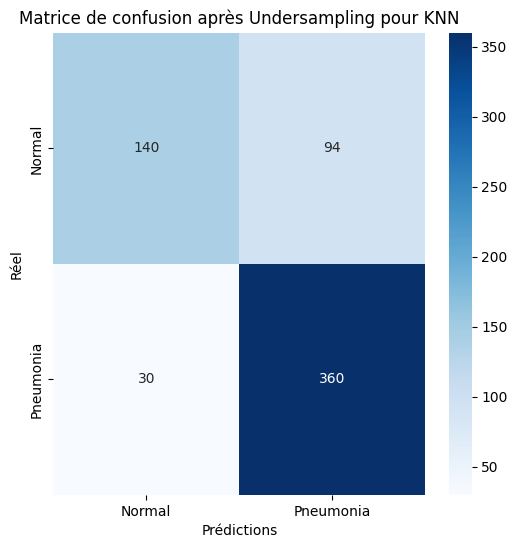

In [146]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Appliquer Random Undersampling pour équilibrer les classes
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = undersampler.fit_resample(X_train_pca, y_train)

# Vérification de l'équilibre des classes après Undersampling
print(f"Distribution des classes après Undersampling :")
print(f"Classe 0 (Normal) : {np.sum(y_train_res == 0)}")
print(f"Classe 1 (Pneumonia) : {np.sum(y_train_res == 1)}")

# Entraîner le modèle KNN avec les données équilibrées
knn_best_res = KNeighborsClassifier(n_neighbors=7, metric='chebyshev')
knn_best_res.fit(X_train_res, y_train_res)

# Prédictions sur l'ensemble de test
y_pred_test_res = knn_best_res.predict(X_test_pca)

# Calcul de l'accuracy sur l'ensemble de test
test_accuracy_res = accuracy_score(y_test, y_pred_test_res)
print(f"Accuracy sur l'ensemble de test après Undersampling : {test_accuracy_res * 100:.2f}%")

# Affichage du Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_test_res, target_names=["Normal", "Pneumonia"]))

# Calcul de la matrice de confusion
conf_matrix_res = confusion_matrix(y_test, y_pred_test_res)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_res, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion après Undersampling pour KNN")
plt.show()


## NB

Distribution des classes après Undersampling :
Classe 0 (Normal) : 1341
Classe 1 (Pneumonia) : 1341
Accuracy sur l'ensemble de test après Undersampling : 52.72%

Classification Report :
              precision    recall  f1-score   support

      Normal       0.44      0.88      0.58       234
   Pneumonia       0.81      0.32      0.46       390

    accuracy                           0.53       624
   macro avg       0.62      0.60      0.52       624
weighted avg       0.67      0.53      0.50       624



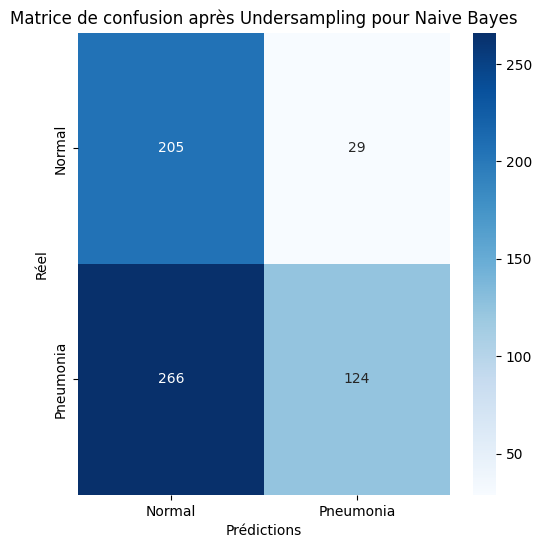

In [145]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Appliquer le RandomUnderSampler pour équilibrer les classes
under_sampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = under_sampler.fit_resample(X_train_pca, y_train)

# Vérification de l'équilibre des classes après Undersampling
print(f"Distribution des classes après Undersampling :")
print(f"Classe 0 (Normal) : {np.sum(y_train_res == 0)}")
print(f"Classe 1 (Pneumonia) : {np.sum(y_train_res == 1)}")

# Initialiser le modèle Naive Bayes
nb_model_res = GaussianNB()

# Entraîner le modèle Naive Bayes avec les données équilibrées
nb_model_res.fit(X_train_res, y_train_res)

# Prédictions sur l'ensemble de test
y_pred_test_res = nb_model_res.predict(X_test_pca)

# Calcul de l'accuracy sur l'ensemble de test
test_accuracy_res = accuracy_score(y_test, y_pred_test_res)
print(f"Accuracy sur l'ensemble de test après Undersampling : {test_accuracy_res * 100:.2f}%")

# Affichage du Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_test_res, target_names=["Normal", "Pneumonia"]))

# Calcul de la matrice de confusion
conf_matrix_res = confusion_matrix(y_test, y_pred_test_res)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_res, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion après Undersampling pour Naive Bayes")
plt.show()

## SVM

Distribution des classes après SMOTE :
Classe 0 (Normal) : 1341
Classe 1 (Pneumonia) : 1341
Accuracy sur l'ensemble de test après SMOTE (SVM) : 79.49%

Classification Report :
              precision    recall  f1-score   support

      Normal       0.97      0.47      0.63       234
   Pneumonia       0.76      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.84      0.79      0.77       624



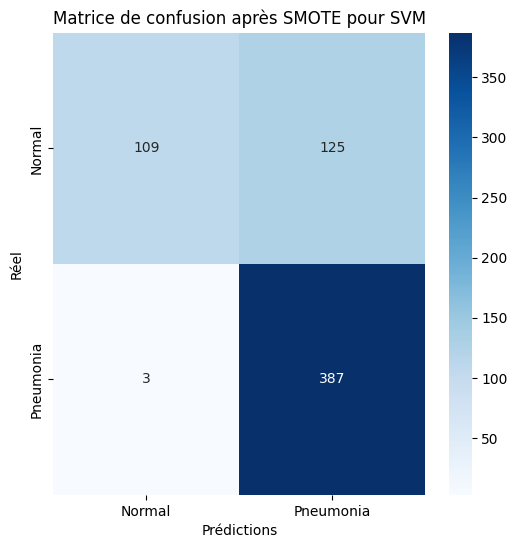

In [144]:
# Vérification de l'équilibre des classes après SMOTE
print(f"Distribution des classes après SMOTE :")
print(f"Classe 0 (Normal) : {np.sum(y_train_res == 0)}")
print(f"Classe 1 (Pneumonia) : {np.sum(y_train_res == 1)}")

# Initialisation du modèle SVM avec un noyau linéaire
svm_model = SVC(kernel='linear', random_state=42)

# Entraîner le modèle SVM avec les données rééquilibrées
svm_model.fit(X_train_res, y_train_res)

# Prédictions sur l'ensemble de test
y_pred_test_svm = svm_model.predict(X_test_pca)

# Calcul de l'accuracy sur l'ensemble de test
test_accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
print(f"Accuracy sur l'ensemble de test après SMOTE (SVM) : {test_accuracy_svm * 100:.2f}%")

# Affichage du classification report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_test_svm, target_names=["Normal", "Pneumonia"]))

# Calcul de la matrice de confusion
conf_matrix_svm = confusion_matrix(y_test, y_pred_test_svm)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion après SMOTE pour SVM")
plt.show()


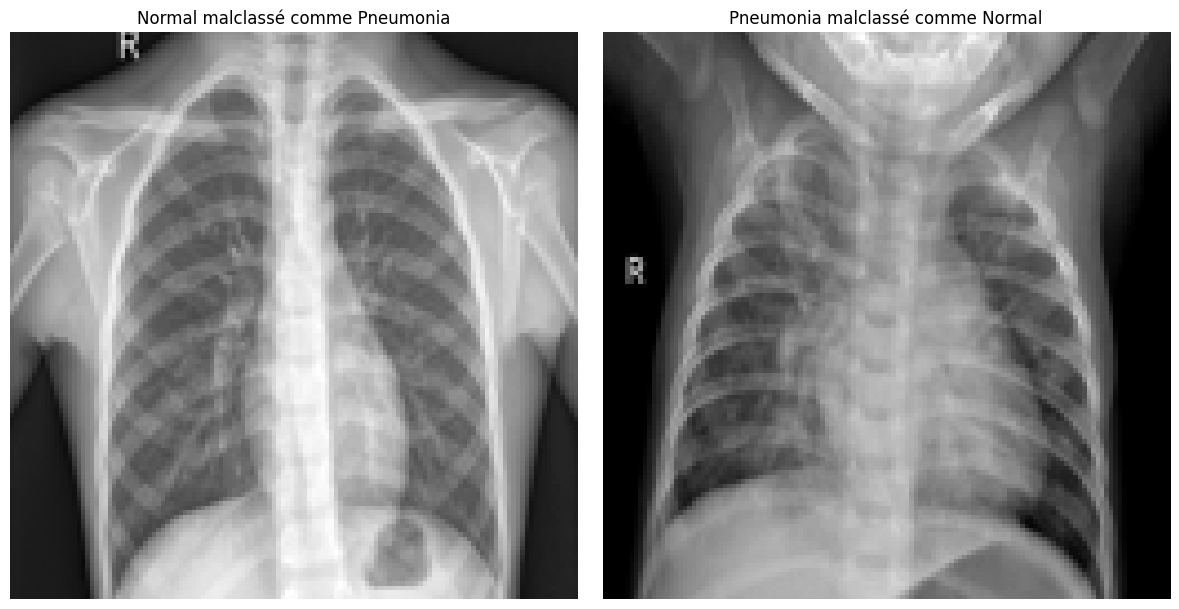

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assurez-vous que vous avez les images originales (par exemple, data['test']) et que y_test et y_pred_test sont également définis

# Taille d'image originale (avant extraction de HOG)
image_size = 128  # La taille d'image d'origine que vous avez redimensionnée

# Trouver un "Normal" malclassé comme "Pneumonia"
index_normal_misclassified = np.where((y_test == 0) & (y_pred_test == 1))[0]

# Trouver un "Pneumonia" malclassé comme "Normal"
index_pneumonia_misclassified = np.where((y_test == 1) & (y_pred_test == 0))[0]

# Vérifier si des malclassements existent
if len(index_normal_misclassified) > 0 and len(index_pneumonia_misclassified) > 0:
    # Si des malclassements existent, on les prend
    index_normal_misclassified = index_normal_misclassified[0]  # Choisir un exemple malclassé
    index_pneumonia_misclassified = index_pneumonia_misclassified[0]  # Choisir un exemple malclassé
    
    # Afficher les deux images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Afficher l'image malclassée comme Pneumonia (Normal)
    axes[0].imshow(data['test'][index_normal_misclassified].reshape(image_size, image_size), cmap='gray')  # Affichage de l'image originale
    axes[0].set_title("Normal malclassé comme Pneumonia")
    axes[0].axis('off')  # Ne pas afficher les axes

    # Afficher l'image malclassée comme Normal (Pneumonia)
    axes[1].imshow(data['test'][index_pneumonia_misclassified].reshape(image_size, image_size), cmap='gray')  # Affichage de l'image originale
    axes[1].set_title("Pneumonia malclassé comme Normal")
    axes[1].axis('off')  # Ne pas afficher les axes

    # Sauvegarder les images
    # Convertir les images en entiers de 0 à 255 avant de les sauvegarder
    image_normal_misclassified = Image.fromarray((data['test'][index_normal_misclassified].reshape(image_size, image_size) * 255).astype(np.uint8))
    image_normal_misclassified = image_normal_misclassified.convert('L')  # Convertir en mode 'L' (niveau de gris)

    image_normal_misclassified.save('normal_misclassified_as_pneumonia.png')

    image_pneumonia_misclassified = Image.fromarray((data['test'][index_pneumonia_misclassified].reshape(image_size, image_size) * 255).astype(np.uint8))
    image_pneumonia_misclassified = image_pneumonia_misclassified.convert('L')  # Convertir en mode 'L' (niveau de gris)

    image_pneumonia_misclassified.save('pneumonia_misclassified_as_normal.png')

    # Afficher les images
    plt.tight_layout()
    plt.show()
else:
    print("Il n'y a pas d'exemples malclassés de chaque type.")


# Model CNN 

In [207]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [189]:
COUNT_NORMAL = {"train": 0, "test": 0, "val": 0}
COUNT_PNEUMONIA = {"train": 0, "test": 0, "val": 0}

def load_and_preprocess_images(folder_path, label, split):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize the image
            img = np.array(img) / 255.0  # Normalize between 0 and 1
            images.append(img)
            labels.append(label)
            
            # Update counts
            if label == 0:  # NORMAL
                COUNT_NORMAL[split] += 1
            else:  # PNEUMONIA
                COUNT_PNEUMONIA[split] += 1
                
        except Exception as e:
            print(f"Corrupted image: {file_path}, error: {e}")
    return images, labels


In [191]:
data = {"train": [], "test": [], "val": []}
labels = {"train": [], "test": [], "val": []}

# Remplacer ces variables par tes chemins réels
dataset_path = "chest_xray"
subdirs = ["train", "test", "val"]  # Les sous-dossiers contenant les images
categories = ["NORMAL", "PNEUMONIA"]  # Les catégories à traiter

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, lbls = load_and_preprocess_images(folder_path, category_label, subdir)
        data[subdir].extend(images)
        labels[subdir].extend(lbls)

# Conversion en numpy arrays et ajout de la dimension canal (pour CNN)
for key in data:
    data[key] = np.expand_dims(np.array(data[key]), axis=-1)  # Ajout de la dimension canal (grayscale)
    labels[key] = np.array(labels[key])


In [192]:
# Dupliquer le canal NDG pour obtenir 3 canaux (compatible avec les modèles pré-entraînés)
data["train"] = np.repeat(data["train"], 3, axis=-1)  
data["test"] = np.repeat(data["test"], 3, axis=-1)
data["val"] = np.repeat(data["val"], 3, axis=-1)  # Si tu utilises la validation


In [193]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2  # 20% des images pour la validation
)

# Création des générateurs
train_generator = train_datagen.flow(
    data["train"], labels["train"],  # ✅ Données déjà chargées
    batch_size=32,
    shuffle=True
)

test_generator = train_datagen.flow(
    data["test"], labels["test"],  
    batch_size=32,
    shuffle=False  # Pas besoin de shuffle pour le test
)


In [210]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Gel des couches du modèle pré-entraîné pour ne pas les entraîner à nouveau
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées à la fin
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])




In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,  # Utilisation des images de test pour la validation
    epochs=10,  # Ajustable selon le dataset
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),  # Correction ici
    verbose=1
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 848ms/step - accuracy: 0.7271 - loss: 0.5949 - val_accuracy: 0.6250 - val_loss: 0.6718
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 854ms/step - accuracy: 0.7416 - loss: 0.5803 - val_accuracy: 0.6250 - val_loss: 0.6698
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 848ms/step - accuracy: 0.7469 - loss: 0.5723 - val_accuracy: 0.6250 - val_loss: 0.6647
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 862ms/step - accuracy: 0.7411 - loss: 0.5843 - val_accuracy: 0.6250 - val_loss: 0.6816
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 871ms/step - accuracy: 0.7462 - loss: 0.5729 - val_accuracy: 0.6250 - val_loss: 0.7514
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 863ms/step - accuracy: 0.7413 - loss: 0.5799 - val_accuracy: 0.6250 - val_loss: 0.6714
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 863ms/step - accuracy: 0.7494 - loss: 0.5723 - val_accuracy: 0.6250 - val_loss: 0.6884
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 873ms/step - accuracy: 0.7463 -

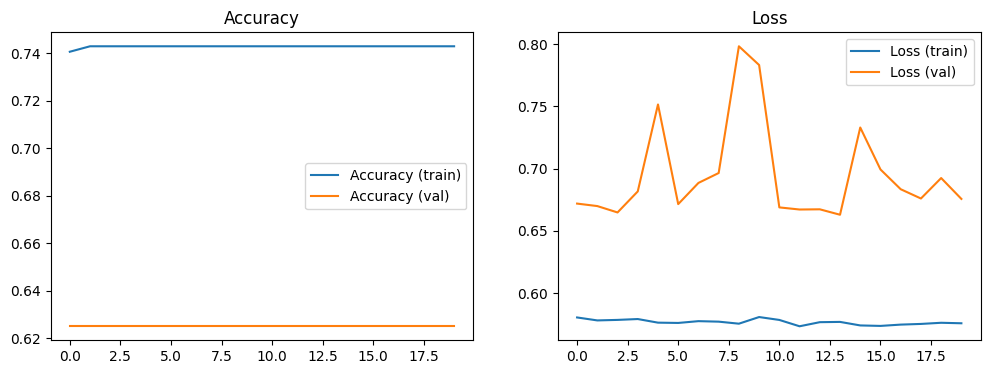

In [196]:
# Visualisation des courbes de perte et d'exactitude
plt.figure(figsize=(12, 4))

# Courbe de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)')
plt.title('Accuracy')
plt.legend()

# Courbe de la loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Loss')
plt.legend()

plt.show()


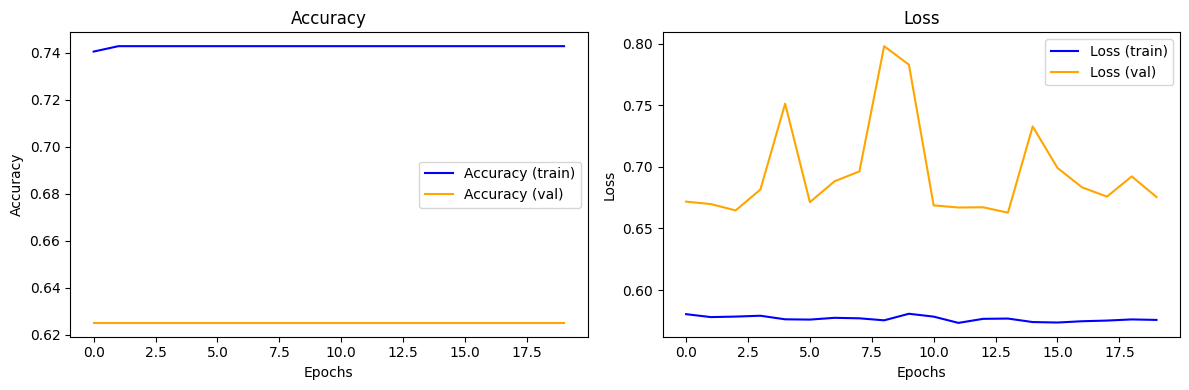

In [197]:
import matplotlib.pyplot as plt

# Visualisation des courbes de perte et d'exactitude
plt.figure(figsize=(12, 4))

# Courbe de l'accuracy (précision)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (train)', color='blue')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)', color='orange')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de la loss (perte)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (train)', color='blue')
plt.plot(history.history['val_loss'], label='Loss (val)', color='orange')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 724ms/step
Test Accuracy: 62.50%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

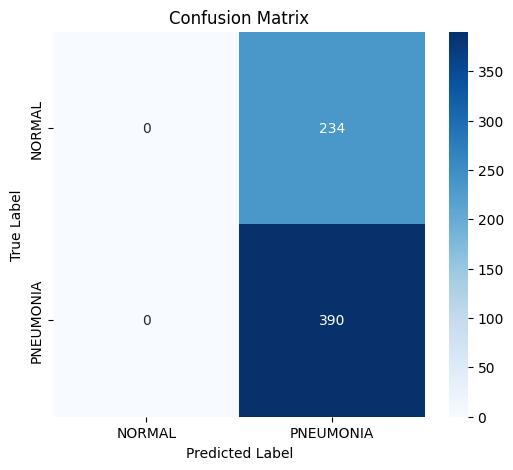

In [198]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# Prédictions sur l'ensemble de test
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype("int32")  # Convertir les prédictions en labels (0 ou 1)

# Précision sur l'ensemble de test
test_accuracy = accuracy_score(labels["test"], test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Rapport de classification
print("\nClassification Report:")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# Matrice de confusion
cm = confusion_matrix(labels["test"], test_predictions)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()


# Model 2

In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
dataset_path = "chest_xray"

# Define the subdirectories for train, test, and validation
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]
COUNT_NORMAL = {"train": 0, "test": 0, "val": 0}
COUNT_PNEUMONIA = {"train": 0, "test": 0, "val": 0}

def load_and_preprocess_images(folder_path, label, split):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize the image
            img = np.array(img) / 255.0  # Normalize between 0 and 1
            images.append(img)
            labels.append(label)
            
            # Update counts
            if label == 0:  # NORMAL
                COUNT_NORMAL[split] += 1
            else:  # PNEUMONIA
                COUNT_PNEUMONIA[split] += 1
                
        except Exception as e:
            print(f"Corrupted image: {file_path}, error: {e}")
    return images, labels

data = {"train": [], "test": [], "val": []}
labels = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, lbls = load_and_preprocess_images(folder_path, category_label, subdir)
        data[subdir].extend(images)
        labels[subdir].extend(lbls)

# Conversion en numpy arrays et ajout de la dimension canal (pour CNN)
for key in data:
    data[key] = np.expand_dims(np.array(data[key]), axis=-1)  
    labels[key] = np.array(labels[key])

In [3]:
print("Nombre d'images par classe :")
for split in subdirs:
    print(f"{split.upper()}:")
    print(f"  NORMAL: {COUNT_NORMAL[split]}")
    print(f"  PNEUMONIA: {COUNT_PNEUMONIA[split]}")

Nombre d'images par classe :
TRAIN:
  NORMAL: 1341
  PNEUMONIA: 3875
TEST:
  NORMAL: 234
  PNEUMONIA: 390
VAL:
  NORMAL: 8
  PNEUMONIA: 8


In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Redimensionner les images pour correspondre au modèle pré-entraîné
input_shape = (128, 128, 3)  # Modèle pré-entraîné attend des images RGB
train_data_rgb = np.repeat(data["train"], 3, axis=-1)  # Convertir en RGB
val_data_rgb = np.repeat(data["val"], 3, axis=-1)      # Convertir en RGB

# Créer des générateurs
train_generator = datagen.flow(train_data_rgb, labels["train"], batch_size=32)
val_generator = datagen.flow(val_data_rgb, labels["val"], batch_size=32)

In [5]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [242]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=2,
                    steps_per_epoch=len(data["train"]) // 32,
                    validation_steps=len(data["val"]) // 32)

C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 154s 921ms/step - accuracy: 0.6985 - loss: 0.6069 - val_accuracy: 0.5000 - val_loss: 0.7382
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 846ms/step - accuracy: 0.7509 - loss: 0.5078 - val_accuracy: 0.5000 - val_loss: 0.7161


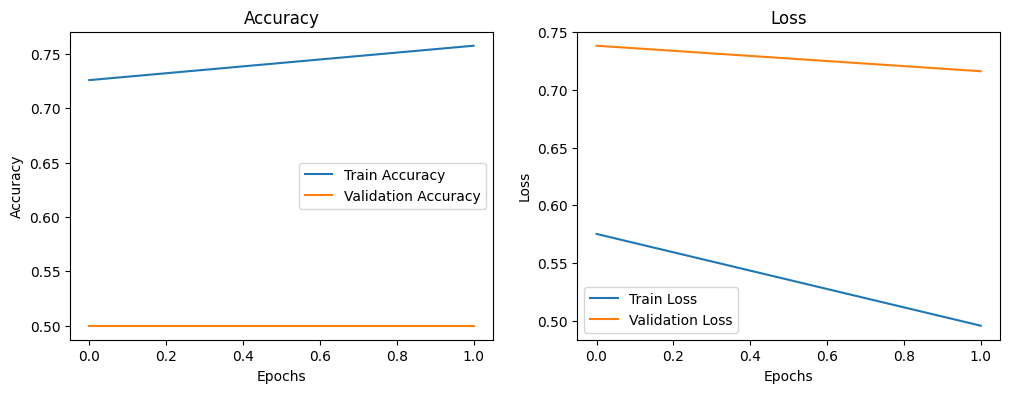

In [243]:
plt.figure(figsize=(12, 4))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Regrouper toutes les données
all_images = np.concatenate([data["train"], data["test"], data["val"]])
all_labels = np.concatenate([labels["train"], labels["test"], labels["val"]])

# Diviser en train/validation/test
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Mettre à jour les données
data["train"] = X_train
data["val"] = X_val
data["test"] = X_test
labels["train"] = y_train
labels["val"] = y_val
labels["test"] = y_test

In [9]:
input_shape = (224, 224, 3)  # Taille attendue par VGG16

# Convertir en RGB et redimensionner
def preprocess_images(images):
    images_rgb = np.repeat(images, 3, axis=-1)  # Convertir en RGB
    images_resized = np.array([tf.image.resize(img, [224, 224]) for img in images_rgb])
    return images_resized

data["train"] = preprocess_images(data["train"])
data["val"] = preprocess_images(data["val"])
data["test"] = preprocess_images(data["test"])

In [246]:
# Geler les premières couches et dégeler les dernières
for layer in base_model.layers[:-4]:  # Garder les 4 dernières couches non gelées
    layer.trainable = False

In [248]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    steps_per_epoch=len(data["train"]) // 32,
                    validation_steps=len(data["val"]) // 32)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 113s 772ms/step - accuracy: 0.8024 - loss: 0.4093 - val_accuracy: 0.5625 - val_loss: 0.6553
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8202 - loss: 0.3980 - val_accuracy: 0.5625 - val_loss: 0.6172
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 110s 755ms/step - accuracy: 0.8289 - loss: 0.3790 - val_accuracy: 0.6250 - val_loss: 0.5447
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.8342 - loss: 0.3629 - val_accuracy: 0.5625 - val_loss: 0.5525
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 115s 787ms/step - accuracy: 0.8376 - loss: 0.3505 - val_accuracy: 0.6875 - val_loss: 0.5512
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.8449 - loss: 0.3292 - val_accuracy: 0.5625 - val_loss: 0.6399
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 114s 779ms/step - accuracy: 0.8512 - loss: 0.3325 - val_accuracy: 0.7500 - val_loss: 0.4481
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.8606 - loss: 0

In [250]:
# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Entraîner le modèle
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    steps_per_epoch=len(data["train"]) // 32,
                    validation_steps=len(data["test"]) // 32)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 115s 779ms/step - accuracy: 0.8776 - loss: 0.2891 - val_accuracy: 0.6875 - val_loss: 0.5875
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.8765 - loss: 0.2880 - val_accuracy: 0.6250 - val_loss: 0.6523
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 113s 772ms/step - accuracy: 0.8735 - loss: 0.2891 - val_accuracy: 0.6875 - val_loss: 0.5449
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.8694 - loss: 0.3039 - val_accuracy: 0.7500 - val_loss: 0.4736
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 114s 781ms/step - accuracy: 0.8713 - loss: 0.3008 - val_accuracy: 0.6875 - val_loss: 0.5596
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.8660 - loss: 0.2976 - val_accuracy: 0.6875 - val_loss: 0.5659
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 118s 810ms/step - accuracy: 0.8724 - loss: 0.2916 - val_accuracy: 0.6875 - val_loss: 0.5485
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.8621 - loss: 

In [10]:
# Convertir en RGB et redimensionner
def preprocess_images(images):
    images_rgb = np.repeat(images, 3, axis=-1)  # Convertir en RGB
    images_resized = np.array([tf.image.resize(img, [224, 224]) for img in images_rgb])
    return images_resized

data["test"] = preprocess_images(data["test"])

In [11]:
print("Forme initiale des données d'entraînement :", data["train"].shape)
print("Type des données d'entraînement :", data["train"].dtype)

Forme initiale des données d'entraînement : (4684, 224, 224, 3)
Type des données d'entraînement : float32


In [12]:
def preprocess_images_one_by_one(images, target_size=(224, 224)):
    resized_images = []
    for img in images:
        # Convertir en RGB si nécessaire
        if img.shape[-1] == 1:  # Si l'image est en niveaux de gris
            img = np.repeat(img, 3, axis=-1)
        
        # Redimensionner l'image
        resized_img = tf.image.resize(img, target_size)
        resized_images.append(resized_img.numpy())  # Convertir en NumPy

    return np.array(resized_images)

# Prétraiter les ensembles d'entraînement, de validation et de test
data["train"] = preprocess_images_one_by_one(data["train"])
data["val"] = preprocess_images_one_by_one(data["val"])
data["test"] = preprocess_images_one_by_one(data["test"])

In [13]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, target_size=(224, 224)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prétraiter les images
        batch_images_processed = []
        for img in batch_images:
            if img.shape[-1] == 1:  # Si l'image est en niveaux de gris
                img = np.repeat(img, 3, axis=-1)
            resized_img = tf.image.resize(img, self.target_size)
            batch_images_processed.append(resized_img.numpy())

        return np.array(batch_images_processed), batch_labels

# Créer des générateurs pour l'entraînement, la validation et le test
batch_size = 32
train_generator = DataGenerator(data["train"], labels["train"], batch_size=batch_size)
val_generator = DataGenerator(data["val"], labels["val"], batch_size=batch_size)
test_generator = DataGenerator(data["test"], labels["test"], batch_size=batch_size)

In [14]:
def preprocess_images(images, target_size=(64, 64)):
    resized_images = []
    for img in images:
        if img.shape[-1] == 1:  # Si l'image est en niveaux de gris
            img = np.repeat(img, 3, axis=-1)
        resized_img = tf.image.resize(img, target_size)
        resized_images.append(resized_img.numpy())
    return np.array(resized_images)

# Prétraiter les ensembles d'entraînement, de validation et de test
data["train"] = preprocess_images(data["train"], target_size=(64, 64))
data["val"] = preprocess_images(data["val"], target_size=(64, 64))
data["test"] = preprocess_images(data["test"], target_size=(64, 64))

In [15]:
from tensorflow.keras.utils import Sequence

class TestDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, target_size=(224, 224)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prétraiter les images
        batch_images_processed = []
        for img in batch_images:
            if img.shape[-1] == 1:  # Si l'image est en niveaux de gris
                img = np.repeat(img, 3, axis=-1)
            resized_img = tf.image.resize(img, self.target_size)
            batch_images_processed.append(resized_img.numpy())

        return np.array(batch_images_processed), batch_labels

# Créer un générateur pour l'ensemble de test
batch_size = 32
test_generator = TestDataGenerator(data["test"], labels["test"], batch_size=batch_size)

In [19]:
# Vérifier la forme des données générées
for batch_images, batch_labels in test_generator:
    print("Shape des images dans le batch :", batch_images.shape)
    print("Type des images :", batch_images.dtype)
    break  # Afficher seulement le premier batch

Shape des images dans le batch : (32, 224, 224, 9)
Type des images : float32


In [20]:
def preprocess_image(img, target_size=(128, 128)):
    if img.shape[-1] == 1:  # Si l'image est en niveaux de gris
        img = np.repeat(img, 3, axis=-1)  # Convertir en RGB
    resized_img = tf.image.resize(img, target_size)  # Redimensionner
    return resized_img.numpy()

class TestDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, target_size=(128, 128)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prétraiter les images
        batch_images_processed = [preprocess_image(img, self.target_size) for img in batch_images]
        return np.array(batch_images_processed), batch_labels

In [21]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

In [ ]:
print("Forme des données de test :", data["test"].shape)

In [24]:
# Vérifier la forme des données de test
print("Forme des données de test :", data["test"].shape)
print("Type des données de test :", data["test"].dtype)

Forme des données de test : (586, 64, 64, 9)
Type des données de test : float32


In [25]:
from tensorflow.keras.utils import Sequence

class TestDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, target_size=(128, 128)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prétraiter les images
        batch_images_processed = []
        for img in batch_images:
            if img.shape[-1] == 1:  # Si l'image est en niveaux de gris
                img = np.repeat(img, 3, axis=-1)  # Convertir en RGB
            resized_img = tf.image.resize(img, self.target_size)  # Redimensionner
            batch_images_processed.append(resized_img.numpy())

        return np.array(batch_images_processed), batch_labels

In [26]:
# Créer un générateur pour l'ensemble de test
batch_size = 32
test_generator = TestDataGenerator(data["test"], labels["test"], batch_size=batch_size)

In [28]:
def preprocess_image(img, target_size=(128, 128)):
    # Vérifier si l'image est en niveaux de gris (1 canal)
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)  # Convertir en RGB (3 canaux)
    elif img.shape[-1] != 3:
        raise ValueError(f"Image inattendue avec {img.shape[-1]} canaux. Seuls 1 ou 3 canaux sont pris en charge.")
    
    # Redimensionner l'image
    resized_img = tf.image.resize(img, target_size)
    return resized_img.numpy()

In [29]:
class TestDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, target_size=(128, 128)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prétraiter les images
        batch_images_processed = [preprocess_image(img, self.target_size) for img in batch_images]
        return np.array(batch_images_processed), batch_labels

In [33]:
def preprocess_image(img, target_size=(128, 128)):
    # Conserver uniquement le premier canal si l'image a plus de 3 canaux
    if img.shape[-1] > 3:
        img = img[:, :, :1]  # Garder uniquement le premier canal
    
    # Convertir en RGB si nécessaire
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)  # Convertir en RGB (3 canaux)
    
    # Redimensionner l'image
    resized_img = tf.image.resize(img, target_size)
    return resized_img.numpy()

In [34]:
class TestDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, target_size=(128, 128)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prétraiter les images
        batch_images_processed = [preprocess_image(img, self.target_size) for img in batch_images]
        return np.array(batch_images_processed), batch_labels

In [35]:
# Créer un générateur pour l'ensemble de test
batch_size = 32
test_generator = TestDataGenerator(data["test"], labels["test"], batch_size=batch_size)

# Vérifier la forme des données générées
for batch_images, batch_labels in test_generator:
    print("Shape des images dans le batch :", batch_images.shape)
    print("Type des images :", batch_images.dtype)
    break  # Afficher seulement le premier batch

Shape des images dans le batch : (32, 128, 128, 3)
Type des images : float32


In [38]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger le modèle pré-entraîné
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [40]:
def preprocess_image(img, target_size=(64, 64)):
    # Conserver uniquement le premier canal si l'image a plus de 3 canaux
    if img.shape[-1] > 3:
        img = img[:, :, :1]  # Garder uniquement le premier canal
    
    # Convertir en RGB si nécessaire
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)  # Convertir en RGB (3 canaux)
    
    # Redimensionner l'image
    resized_img = tf.image.resize(img, target_size)
    return resized_img.numpy()

In [41]:
class TestDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, target_size=(64, 64)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prétraiter les images
        batch_images_processed = [preprocess_image(img, self.target_size) for img in batch_images]
        return np.array(batch_images_processed), batch_labels

In [42]:
# Créer un générateur pour l'ensemble de test
batch_size = 32
test_generator = TestDataGenerator(data["test"], labels["test"], batch_size=batch_size)

# Vérifier la forme des données générées
for batch_images, batch_labels in test_generator:
    print("Shape des images dans le batch :", batch_images.shape)
    print("Type des images :", batch_images.dtype)
    break  # Afficher seulement le premier batch

Shape des images dans le batch : (32, 64, 64, 3)
Type des images : float32


In [44]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger le modèle pré-entraîné avec une taille d'entrée de (64, 64, 3)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [45]:
# Créer un générateur pour l'ensemble de test
batch_size = 32
test_generator = TestDataGenerator(data["test"], labels["test"], batch_size=batch_size)

# Vérifier la forme des données générées
for batch_images, batch_labels in test_generator:
    print("Shape des images dans le batch :", batch_images.shape)
    print("Type des images :", batch_images.dtype)
    break  # Afficher seulement le premier batch

Shape des images dans le batch : (32, 64, 64, 3)
Type des images : float32


In [46]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)  # Désactiver tf.function

In [47]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.7297 - loss: 0.6365
Test Loss: 0.6301335692405701
Test Accuracy: 0.7337883710861206


In [50]:
# Obtenir les prédictions
y_pred = []
y_true = []

for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator[i]
    batch_predictions = (model.predict(batch_images) > 0.5).astype("int32")  # Seuil à 0.5
    y_pred.extend(batch_predictions.flatten())
    y_true.extend(batch_labels.flatten())

C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


In [51]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       156
   PNEUMONIA       0.73      1.00      0.85       430

    accuracy                           0.73       586
   macro avg       0.37      0.50      0.42       586
weighted avg       0.54      0.73      0.62       586



C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [52]:
from sklearn.utils import resample

# Séparer les classes
normal_images = data["train"][labels["train"] == 0]
pneumonia_images = data["train"][labels["train"] == 1]

# Oversampler la classe "NORMAL"
normal_images_resampled = resample(normal_images,
                                   replace=True,
                                   n_samples=len(pneumonia_images),
                                   random_state=42)

# Recombiner les données
data["train"] = np.concatenate([normal_images_resampled, pneumonia_images])
labels["train"] = np.concatenate([np.zeros(len(normal_images_resampled)), np.ones(len(pneumonia_images))])

In [53]:
# Undersampler la classe "PNEUMONIA"
pneumonia_images_resampled = resample(pneumonia_images,
                                      replace=False,
                                      n_samples=len(normal_images),
                                      random_state=42)

# Recombiner les données
data["train"] = np.concatenate([normal_images, pneumonia_images_resampled])
labels["train"] = np.concatenate([np.zeros(len(normal_images)), np.ones(len(pneumonia_images_resampled))])

In [57]:
from tensorflow.keras.applications import VGG16

# Charger le modèle pré-entraîné avec une taille d'entrée de (64, 64, 3)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

In [58]:
def preprocess_image(img, target_size=(64, 64)):
    # Conserver uniquement le premier canal si l'image a plus de 3 canaux
    if img.shape[-1] > 3:
        img = img[:, :, :1]  # Garder uniquement le premier canal
    
    # Convertir en RGB si nécessaire
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)  # Convertir en RGB (3 canaux)
    
    # Redimensionner l'image
    resized_img = tf.image.resize(img, target_size)
    return resized_img.numpy()

In [59]:
class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, target_size=(64, 64)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prétraiter les images
        batch_images_processed = [preprocess_image(img, self.target_size) for img in batch_images]
        return np.array(batch_images_processed), batch_labels

In [60]:
# Créer un générateur pour l'ensemble d'entraînement
batch_size = 32
train_generator = DataGenerator(data["train"], labels["train"], batch_size=batch_size)

# Vérifier la forme des données générées
for batch_images, batch_labels in train_generator:
    print("Shape des images dans le batch :", batch_images.shape)
    print("Type des images :", batch_images.dtype)
    break  # Afficher seulement le premier batch

Shape des images dans le batch : (32, 64, 64, 3)
Type des images : float32


In [63]:
import tensorflow as tf
import numpy as np

def preprocess_image(img, target_size=(64, 64)):
    # Si l'image a plus de 3 canaux (par exemple, 9 canaux), conservez uniquement les 3 premiers canaux
    if img.shape[-1] > 3:
        img = img[:, :, :3]  # Garder uniquement les 3 premiers canaux
    
    # Si l'image est en niveaux de gris (1 canal), convertissez-la en RGB (3 canaux)
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)  # Convertir en RGB
    
    # Redimensionner l'image
    resized_img = tf.image.resize(img, target_size)
    return resized_img.numpy()

In [64]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, target_size=(64, 64)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prétraiter les images
        batch_images_processed = [preprocess_image(img, self.target_size) for img in batch_images]
        return np.array(batch_images_processed), batch_labels

In [65]:
# Créer des générateurs pour l'entraînement et la validation
batch_size = 32
train_generator = DataGenerator(data["train"], labels["train"], batch_size=batch_size)
val_generator = DataGenerator(data["val"], labels["val"], batch_size=batch_size)

# Vérifier la forme des données générées
for batch_images, batch_labels in train_generator:
    print("Shape des images dans le batch :", batch_images.shape)
    print("Type des images :", batch_images.dtype)
    break  # Afficher seulement le premier batch

Shape des images dans le batch : (32, 64, 64, 3)
Type des images : float32


In [67]:
import numpy as np

# Compter le nombre d'échantillons pour chaque classe
unique, counts = np.unique(labels["train"], return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Distribution des classes avant rééquilibrage :", class_distribution)

Distribution des classes avant rééquilibrage : {np.float64(0.0): np.int64(1248), np.float64(1.0): np.int64(1248)}


In [68]:
from sklearn.utils import resample

# Séparer les images par classe
normal_images = data["train"][labels["train"] == 0]
pneumonia_images = data["train"][labels["train"] == 1]

# Afficher les tailles des classes
print("Nombre d'images 'NORMAL' :", len(normal_images))
print("Nombre d'images 'PNEUMONIA' :", len(pneumonia_images))

Nombre d'images 'NORMAL' : 1248
Nombre d'images 'PNEUMONIA' : 1248


In [70]:
# Oversampler la classe "NORMAL"
normal_images_resampled = resample(normal_images,
                                   replace=True,  # Autoriser la duplication
                                   n_samples=len(pneumonia_images),  # Égaliser avec la classe majoritaire
                                   random_state=42)

# Recombiner les données
data["train"] = np.concatenate([normal_images_resampled, pneumonia_images])
labels["train"] = np.concatenate([np.zeros(len(normal_images_resampled)), np.ones(len(pneumonia_images))])

# Mélanger les données pour éviter un biais d'ordre
from sklearn.utils import shuffle
data["train"], labels["train"] = shuffle(data["train"], labels["train"], random_state=42)

In [71]:
# Nouvelle distribution des classes
unique, counts = np.unique(labels["train"], return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Distribution des classes après oversampling :", class_distribution)

Distribution des classes après oversampling : {np.float64(0.0): np.int64(1248), np.float64(1.0): np.int64(1248)}


In [72]:
# Séparer les images par classe
normal_images = data["train"][labels["train"] == 0]
pneumonia_images = data["train"][labels["train"] == 1]

# Afficher les tailles des classes
print("Nombre d'images 'NORMAL' :", len(normal_images))
print("Nombre d'images 'PNEUMONIA' :", len(pneumonia_images))

Nombre d'images 'NORMAL' : 1248
Nombre d'images 'PNEUMONIA' : 1248


In [73]:
# Undersampler la classe "PNEUMONIA"
pneumonia_images_resampled = resample(pneumonia_images,
                                      replace=False,  # Ne pas autoriser la duplication
                                      n_samples=len(normal_images),  # Égaliser avec la classe minoritaire
                                      random_state=42)

# Recombiner les données
data["train"] = np.concatenate([normal_images, pneumonia_images_resampled])
labels["train"] = np.concatenate([np.zeros(len(normal_images)), np.ones(len(pneumonia_images_resampled))])

# Mélanger les données pour éviter un biais d'ordre
from sklearn.utils import shuffle
data["train"], labels["train"] = shuffle(data["train"], labels["train"], random_state=42)

In [74]:
# Nouvelle distribution des classes
unique, counts = np.unique(labels["train"], return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Distribution des classes après undersampling :", class_distribution)

Distribution des classes après undersampling : {np.float64(0.0): np.int64(1248), np.float64(1.0): np.int64(1248)}


In [75]:
import tensorflow as tf
import numpy as np

def preprocess_image(img, target_size=(64, 64)):
    # Si l'image a plus de 3 canaux (par exemple, 9 canaux), conservez uniquement les 3 premiers canaux
    if img.shape[-1] > 3:
        img = img[:, :, :3]  # Garder uniquement les 3 premiers canaux
    
    # Si l'image est en niveaux de gris (1 canal), convertissez-la en RGB (3 canaux)
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)  # Convertir en RGB
    
    # Redimensionner l'image
    resized_img = tf.image.resize(img, target_size)
    return resized_img.numpy()

# Prétraiter toutes les données
data["train"] = np.array([preprocess_image(img) for img in data["train"]])
data["val"] = np.array([preprocess_image(img) for img in data["val"]])
data["test"] = np.array([preprocess_image(img) for img in data["test"]])

In [76]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_images, batch_labels

# Créer des générateurs
batch_size = 32
train_generator = DataGenerator(data["train"], labels["train"], batch_size=batch_size)
val_generator = DataGenerator(data["val"], labels["val"], batch_size=batch_size)
test_generator = DataGenerator(data["test"], labels["test"], batch_size=batch_size)

In [77]:
# Calculer les poids de classe si nécessaire
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])  # Classes uniques
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels["train"])
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Entraîner le modèle
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(data["train"]) // batch_size,
    validation_steps=len(data["val"]) // batch_size,
    class_weight=class_weights_dict
)

Epoch 1/10


C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 845ms/step - accuracy: 0.6145 - loss: 0.6520 - val_accuracy: 0.8993 - val_loss: 0.5607
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 63s 808ms/step - accuracy: 0.7070 - loss: 0.5885 - val_accuracy: 0.9097 - val_loss: 0.5016
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 835ms/step - accuracy: 0.7670 - loss: 0.5390 - val_accuracy: 0.9149 - val_loss: 0.4580
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 829ms/step - accuracy: 0.8177 - loss: 0.4887 - val_accuracy: 0.9062 - val_loss: 0.4209
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 831ms/step - accuracy: 0.8290 - loss: 0.4554 - val_accuracy: 0.9132 - val_loss: 0.3810
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 847ms/step - accuracy: 0.8638 - loss: 0.4003 - val_accuracy: 0.9045 - val_loss: 0.3593
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 820ms/step - accuracy: 0.8615 - loss: 0.3792 - val_accuracy: 0.9201 - val_loss: 0.3258
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 64s 827ms/step - accuracy: 0.8824 - loss: 0.3494 - val_accuracy: 0.920

In [78]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Obtenir les prédictions
y_pred = []
y_true = []

for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator[i]
    batch_predictions = (model.predict(batch_images) > 0.5).astype("int32")
    y_pred.extend(batch_predictions.flatten())
    y_true.extend(batch_labels.flatten())

# Rapport de classification
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.9061 - loss: 0.2808
Test Loss: 0.2786279320716858
Test Accuracy: 0.914675772190094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
              precision    recall  f1-score   support

      NORMAL       0.79      0.93      0.85       156
   PNEUMONIA

In [79]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Obtenir les prédictions
y_pred = []
y_true = []

for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator[i]
    batch_predictions = (model.predict(batch_images) > 0.5).astype("int32")  # Seuil à 0.5
    y_pred.extend(batch_predictions.flatten())
    y_true.extend(batch_labels.flatten())

C:\Users\NANOPRO\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - accuracy: 0.9061 - loss: 0.2808
Test Loss: 0.2786279320716858
Test Accuracy: 0.914675772190094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [80]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

Rapport de classification :
              precision    recall  f1-score   support

      NORMAL       0.79      0.93      0.85       156
   PNEUMONIA       0.97      0.91      0.94       430

    accuracy                           0.91       586
   macro avg       0.88      0.92      0.90       586
weighted avg       0.92      0.91      0.92       586



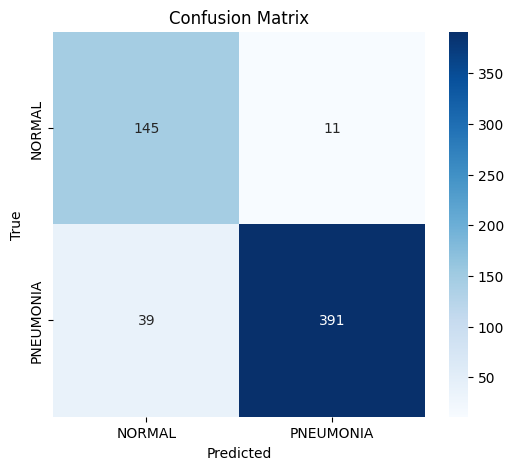

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

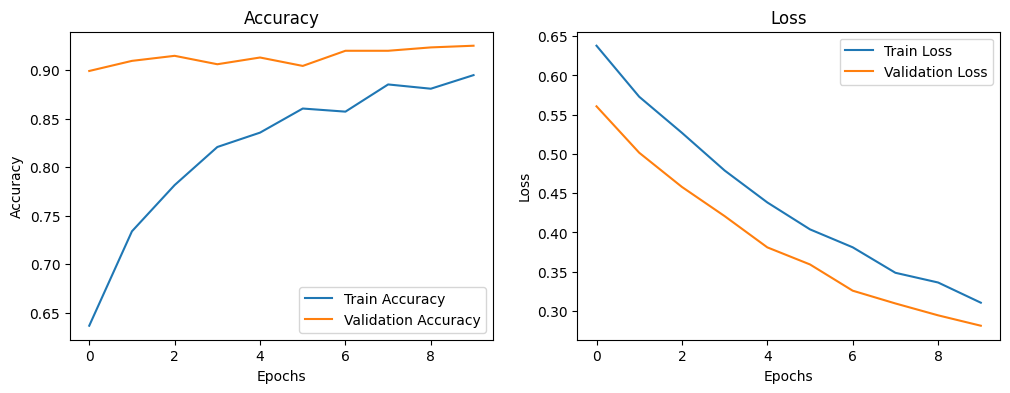

In [82]:
import matplotlib.pyplot as plt

# Courbes d'accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbes de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [84]:
model.save("model.h5")

## Ajustement des paramètres pour réduire la taille des features

In [12]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Vérifier et convertir en niveaux de gris si nécessaire
        if img.ndim == 3 and img.shape[-1] == 3:  
            img = rgb2gray(img)  
        
        # Réduction de dimension si (128,128,1)
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze()  
        
        # Extraire les caractéristiques HOG avec des paramètres optimisés
        features = hog(img, 
                       orientations=6,  # Réduit le nombre de directions
                       pixels_per_cell=(16, 16),  # Agrandit la taille des cellules
                       cells_per_block=(1, 1),  # Évite la redondance
                       block_norm='L2-Hys',
                       feature_vector=True)
        
        hog_features.append(features)
    
    return np.array(hog_features)

train_hog = extract_hog_features(data["train"])
test_hog = extract_hog_features(data["test"])
val_hog = extract_hog_features(data["val"])

print("Taille des features HOG :", train_hog.shape[1])


Taille des features HOG : 384


## Tester le KNN avec les meilleurs paramètres et K-folds pour la détermination du K

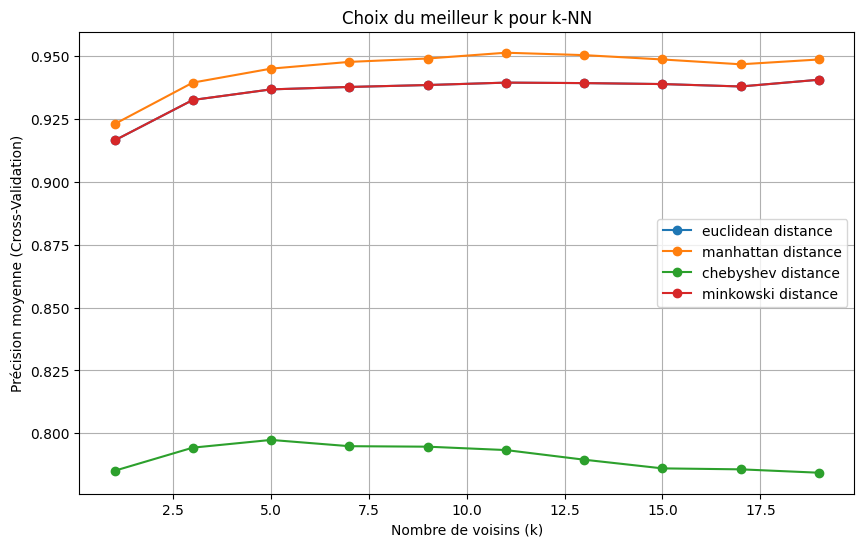

In [16]:

# Stocker les scores pour chaque k
k_scores = {}
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds

for metric in distance_metrics:
    scores_per_k = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, train_hog, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        scores_per_k.append(mean_score)
    
    k_scores[metric] = scores_per_k

# Tracer la courbe
plt.figure(figsize=(10, 6))
for metric, scores in k_scores.items():
    plt.plot(k_values, scores, marker='o', linestyle='-', label=f'{metric} distance')

plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Précision moyenne (Cross-Validation)")
plt.title("Choix du meilleur k pour k-NN")
plt.legend()
plt.grid(True)
plt.show()


 Best k found: 11 with metric 'manhattan' (CV Accuracy: 95.42%)

 Test Accuracy (kNN with manhattan distance, k=11): 77.24%

Classification Report (kNN) on Test Set:
              precision    recall  f1-score   support

      NORMAL       0.93      0.43      0.58       234
   PNEUMONIA       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.83      0.70      0.71       624
weighted avg       0.81      0.77      0.75       624



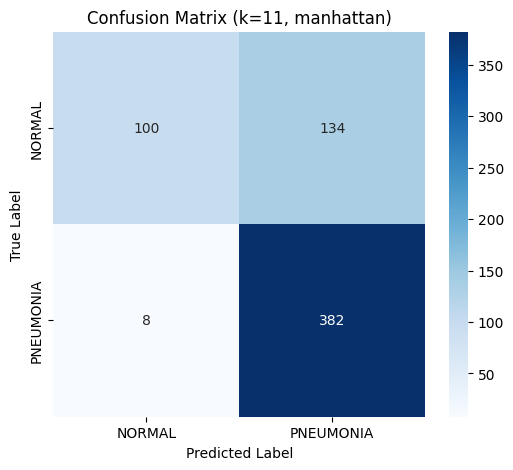

In [111]:
# Standardize features 
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_hog)
test_features = scaler.transform(test_hog)

# Parameters to test
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Best model tracking
best_k = None
best_metric = None
best_score = 0

# Cross-validation loop
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, train_features, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
            
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric

print(f" Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%)")

# Train final model with best parameters
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(train_features, labels["train"])

# Evaluate on TEST set
test_predictions = knn.predict(test_features)
test_accuracy = accuracy_score(labels["test"], test_predictions)

print(f"\n Test Accuracy (kNN with {best_metric} distance, k={best_k}): {test_accuracy * 100:.2f}%")
print("\nClassification Report (kNN) on Test Set:")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric})")
plt.show()


Best k found: 13 with metric 'manhattan' (CV Accuracy: 95.74%) using 15-fold cross-validation

Test Accuracy (kNN with manhattan distance, k=13): 77.88%

Classification Report (kNN) on Test Set:
              precision    recall  f1-score   support

      NORMAL       0.94      0.44      0.60       234
   PNEUMONIA       0.75      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



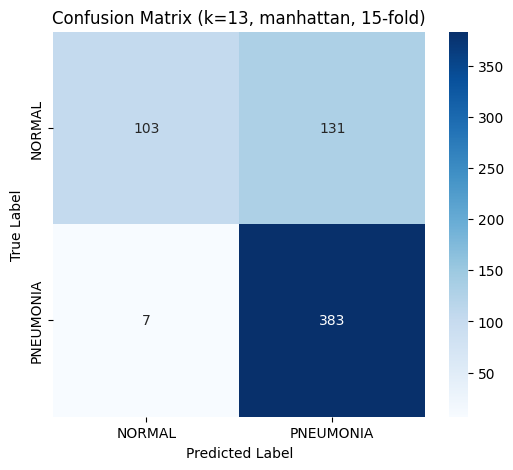

In [13]:

split_values = [3, 5, 7, 10, 15]  
# Best model tracking
best_k = None
best_metric = None
best_score = 0
best_splits = None

# Cross-validation loop
for metric in distance_metrics:
    for k in k_values:
        for splits in split_values:
            cv = StratifiedKFold(n_splits=splits)  # Using different split values
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            scores = cross_val_score(knn, train_features, labels["train"], cv=cv, scoring="accuracy")
            mean_score = scores.mean()
            
            if mean_score > best_score:
                best_score = mean_score
                best_k = k
                best_metric = metric
                best_splits = splits

print(f"Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%) using {best_splits}-fold cross-validation")

# Train final model with best parameters
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(train_features, labels["train"])

# Evaluate on TEST set
test_predictions = knn.predict(test_features)
test_accuracy = accuracy_score(labels["test"], test_predictions)

print(f"\nTest Accuracy (kNN with {best_metric} distance, k={best_k}): {test_accuracy * 100:.2f}%")
print("\nClassification Report (kNN) on Test Set:")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric}, {best_splits}-fold)")
plt.show()


## Undersampling pour équilibrer le jeu de données

In [14]:
X_train_normal = train_features[labels["train"] == 0]
X_train_pneumonia = train_features[labels["train"] == 1]

# Sous-échantillonnage de la classe majoritaire (PNEUMONIA)
X_train_pneumonia_undersampled, y_train_pneumonia_undersampled = resample(
    X_train_pneumonia, 
    labels["train"][labels["train"] == 1], 
    replace=False, 
    n_samples=X_train_normal.shape[0],  # Égale la taille de la classe minoritaire
    random_state=42
)

# Combiner les données sous-échantillonnées avec les données de la classe normale
X_train_balanced = np.vstack([X_train_normal, X_train_pneumonia_undersampled])
y_train_balanced = np.hstack([labels["train"][labels["train"] == 0], y_train_pneumonia_undersampled])

# Vérifier l'équilibre des classes après undersampling
print(f"Classe NORMAL: {np.sum(y_train_balanced == 0)}")
print(f"Classe PNEUMONIA: {np.sum(y_train_balanced == 1)}")


Classe NORMAL: 1341
Classe PNEUMONIA: 1341


## KNN avec les données équilibrées

Meilleur k trouvé : 5 avec une précision de validation croisée : 93.21%
Précision sur le jeu de test (kNN) : 82.69%
Classification Report (kNN) sur le jeu de test :
              precision    recall  f1-score   support

      NORMAL       0.85      0.65      0.74       234
   PNEUMONIA       0.82      0.93      0.87       390

    accuracy                           0.83       624
   macro avg       0.83      0.79      0.80       624
weighted avg       0.83      0.83      0.82       624



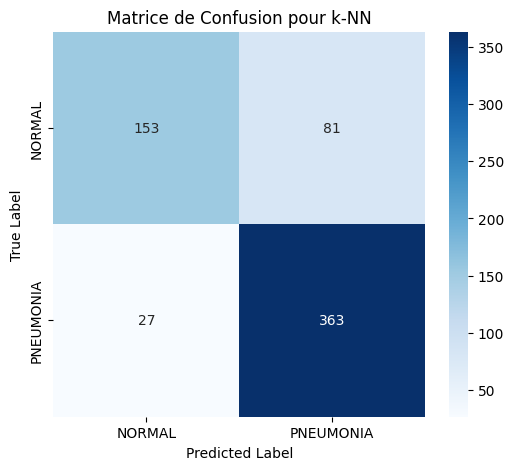

In [17]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(test_features)

best_k = 1
best_score = 0
k_values = range(1, 21, 2)  

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')  # Utilisation de la distance Manhattan
    cv = StratifiedKFold(n_splits=15)  
    scores = cross_val_score(knn, X_train_scaled, y_train_balanced, cv=cv, scoring="accuracy")
    mean_score = scores.mean()
    
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Meilleur k trouvé : {best_k} avec une précision de validation croisée : {best_score * 100:.2f}%")

# 4. Entraînement du modèle kNN avec le meilleur k
knn = KNeighborsClassifier(n_neighbors=best_k, metric='manhattan')
knn.fit(X_train_scaled, y_train_balanced)

# 5. Prédiction sur les données de test
test_predictions = knn.predict(X_test_scaled)

# 6. Calcul de la précision (accuracy) sur les données de test
test_accuracy = accuracy_score(labels["test"], test_predictions)
print(f"Précision sur le jeu de test (kNN) : {test_accuracy * 100:.2f}%")

# 7. Classification Report sur les données de test
print("Classification Report (kNN) sur le jeu de test :")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# 8. Matrice de confusion
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matrice de Confusion pour k-NN")
plt.show()


## Oversampling pour réduire les non-détection 

In [18]:
X_train_normal = train_features[labels["train"] == 0]
X_train_pneumonia = train_features[labels["train"] == 1]

# Sur-échantillonnage de la classe normal
X_train_normal_oversampled, y_train_normal_oversampled = resample(
    X_train_normal, 
    labels["train"][labels["train"] == 0], 
    replace=True,  # Permet de dupliquer les échantillons
    n_samples=X_train_pneumonia.shape[0],  # Égalise la taille de la classe "pneumonia"
    random_state=42
)

# Combiner les données sur-échantillonnées avec les données de la classe pneumonia
X_train_balanced = np.vstack([X_train_normal_oversampled, X_train_pneumonia])
y_train_balanced = np.hstack([y_train_normal_oversampled, labels["train"][labels["train"] == 1]])

# Vérifier l'équilibre des classes après oversampling
print(f"Classe NORMAL (oversampled): {np.sum(y_train_balanced == 0)}")
print(f"Classe PNEUMONIA: {np.sum(y_train_balanced == 1)}")


Classe NORMAL (oversampled): 3875
Classe PNEUMONIA: 3875


Précision sur le jeu de test (kNN) : 83.49%
Classification Report (kNN) sur le jeu de test :
              precision    recall  f1-score   support

      NORMAL       0.91      0.62      0.74       234
   PNEUMONIA       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.85      0.83      0.83       624



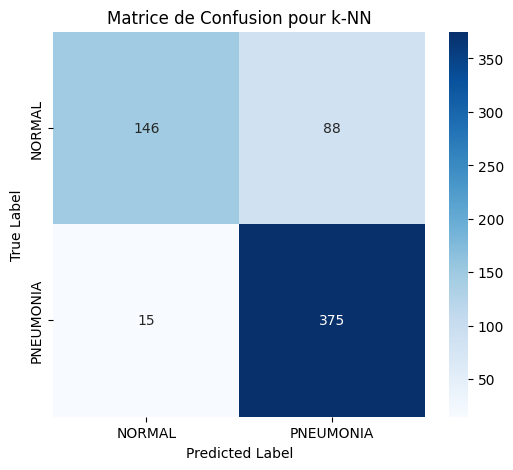

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(test_features)

knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn.fit(X_train_scaled, y_train_balanced)

# 5. Prédiction sur les données de test
test_predictions = knn.predict(X_test_scaled)
    
# 6. Calcul de la précision (accuracy) sur les données de test
test_accuracy = accuracy_score(labels["test"], test_predictions)
print(f"Précision sur le jeu de test (kNN) : {test_accuracy * 100:.2f}%")

# 7. Classification Report sur les données de test
print("Classification Report (kNN) sur le jeu de test :")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# 8. Matrice de confusion
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matrice de Confusion pour k-NN")
plt.show()


### Conclusion :
- Le modèle semble bien fonctionner pour la classe PNEUMONIA, avec un rappel élevé (96%), ce qui signifie que très peu de cas de pneumonie sont manqués.
- Par contre, pour la classe NORMAL, le modèle a une précision élevée (91%), mais son rappel est relativement plus faible (62%), indiquant qu'il manque un nombre significatif de cas "NORMAL". Cela est probablement dû à l'oversampling de la classe NORMAL, qui peut entraîner une certaine confusion avec la classe PNEUMONIA.

## Naive Bayes model avec HOG


Test Accuracy : 73.56%

Classification Report (Naive Bayes) on Test Set:
              precision    recall  f1-score   support

      NORMAL       0.72      0.48      0.58       234
   PNEUMONIA       0.74      0.89      0.81       390

    accuracy                           0.74       624
   macro avg       0.73      0.69      0.69       624
weighted avg       0.73      0.74      0.72       624



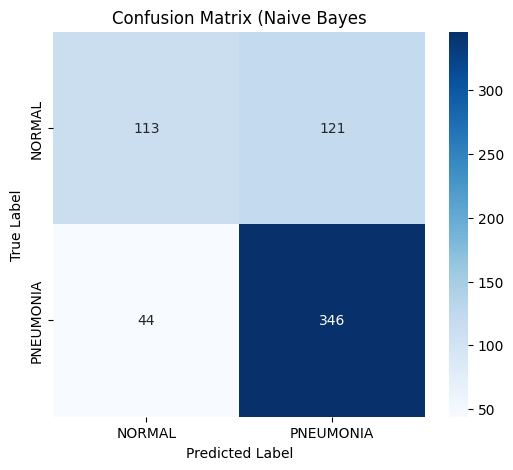

In [22]:
# Standardize features
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_hog)
test_features = scaler.transform(test_hog)

nb = GaussianNB()
nb.fit(train_features, labels["train"])

# Evaluate on TEST set
test_predictions = nb.predict(test_features)
test_accuracy = accuracy_score(labels["test"], test_predictions)

print(f"\nTest Accuracy : {test_accuracy * 100:.2f}%")
print("\nClassification Report (Naive Bayes) on Test Set:")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Naive Bayes")
plt.show()


## Naive bayse avec data undersampled 


Test Accuracy (Naive Bayes - Undersampled): 73.72%

Classification Report (Naive Bayes) on Test Set (Undersampled):
              precision    recall  f1-score   support

      NORMAL       0.72      0.49      0.58       234
   PNEUMONIA       0.74      0.89      0.81       390

    accuracy                           0.74       624
   macro avg       0.73      0.69      0.70       624
weighted avg       0.73      0.74      0.72       624



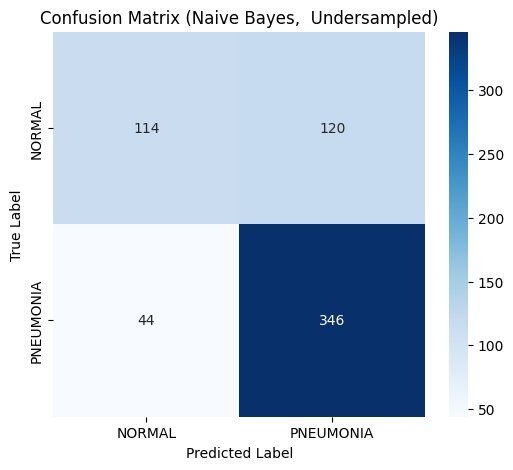

In [23]:

# Sous-échantillonnage des données
X_train_normal = train_features[labels["train"] == 0]
X_train_pneumonia = train_features[labels["train"] == 1]

# Sous-échantillonnage de la classe pneumonia
X_train_pneumonia_undersampled, y_train_pneumonia_undersampled = resample(
    X_train_pneumonia,
    labels["train"][labels["train"] == 1],
    replace=False,  # Ne permet pas de dupliquer les échantillons
    n_samples=X_train_normal.shape[0],  # Égalise la taille de la classe "normal"
    random_state=42
)

# Combiner les données sous-échantillonnées avec les données de la classe normal
X_train_balanced_undersampled = np.vstack([X_train_normal, X_train_pneumonia_undersampled])
y_train_balanced_undersampled = np.hstack([labels["train"][labels["train"] == 0], y_train_pneumonia_undersampled])

# Standardisation des données
scaler = MinMaxScaler()
X_train_scaled_undersampled = scaler.fit_transform(X_train_balanced_undersampled)
X_test_scaled = scaler.transform(test_features)


# Entraîner le modèle final avec les meilleurs paramètres
nb_undersampled = GaussianNB()
nb_undersampled.fit(X_train_scaled_undersampled, y_train_balanced_undersampled)

# Évaluation sur le jeu de test
test_predictions_undersampled = nb_undersampled.predict(X_test_scaled)
test_accuracy_undersampled = accuracy_score(labels["test"], test_predictions_undersampled)

print(f"\nTest Accuracy (Naive Bayes - Undersampled): {test_accuracy_undersampled * 100:.2f}%")
print("\nClassification Report (Naive Bayes) on Test Set (Undersampled):")
print(classification_report(labels["test"], test_predictions_undersampled, target_names=["NORMAL", "PNEUMONIA"]))

# Matrice de confusion
cm_undersampled = confusion_matrix(labels["test"], test_predictions_undersampled)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_undersampled, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Naive Bayes,  Undersampled)")
plt.show()


### Conclusion : 
D'après les résultats obtenus sur le jeu de test, après avoir extrait les caractéristiques HOG des images, il est clair que le modèle k-Nearest Neighbors (kNN) surpasse de loin Naive Bayes en termes de performance pour cette tâche de classification entre les classes NORMAL et PNEUMONIA.


Test Accuracy (Naive Bayes - Oversampled): 74.20%

Classification Report (Naive Bayes) on Test Set (Oversampled):
              precision    recall  f1-score   support

      NORMAL       0.73      0.50      0.59       234
   PNEUMONIA       0.75      0.89      0.81       390

    accuracy                           0.74       624
   macro avg       0.74      0.69      0.70       624
weighted avg       0.74      0.74      0.73       624



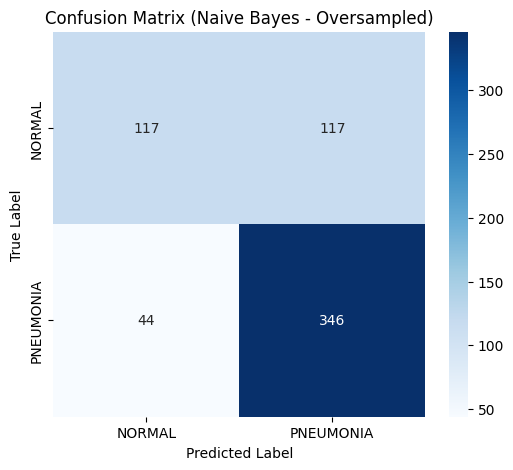

In [24]:

# Sur-échantillonnage des données
X_train_normal = train_features[labels["train"] == 0]
X_train_pneumonia = train_features[labels["train"] == 1]

# Sur-échantillonnage de la classe normal
X_train_normal_oversampled, y_train_normal_oversampled = resample(
    X_train_normal,
    labels["train"][labels["train"] == 0],
    replace=True,  # Permet de dupliquer les échantillons
    n_samples=X_train_pneumonia.shape[0],  # Égalise la taille de la classe "pneumonia"
    random_state=42
)

# Combiner les données sur-échantillonnées avec les données de la classe pneumonia
X_train_balanced_oversampled = np.vstack([X_train_normal_oversampled, X_train_pneumonia])
y_train_balanced_oversampled = np.hstack([y_train_normal_oversampled, labels["train"][labels["train"] == 1]])

# Standardisation des données
scaler = MinMaxScaler()
X_train_scaled_oversampled = scaler.fit_transform(X_train_balanced_oversampled)
X_test_scaled = scaler.transform(test_features)


# Entraîner le modèle final avec les meilleurs paramètres
nb_oversampled = GaussianNB()
nb_oversampled.fit(X_train_scaled_oversampled, y_train_balanced_oversampled)

# Évaluation sur le jeu de test
test_predictions_oversampled = nb_oversampled.predict(X_test_scaled)
test_accuracy_oversampled = accuracy_score(labels["test"], test_predictions_oversampled)

print(f"\nTest Accuracy (Naive Bayes - Oversampled): {test_accuracy_oversampled * 100:.2f}%")
print("\nClassification Report (Naive Bayes) on Test Set (Oversampled):")
print(classification_report(labels["test"], test_predictions_oversampled, target_names=["NORMAL", "PNEUMONIA"]))

# Matrice de confusion
cm_oversampled = confusion_matrix(labels["test"], test_predictions_oversampled)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_oversampled, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Naive Bayes - Oversampled)")
plt.show()


# 2-HISTOGRAM feature

In [ ]:
def extract_histogram_features(images, bins=32, group_size=4):
    hist_features = []

    for img in images:
        if img.ndim == 3 and img.shape[-1] == 3:
            img = rgb2gray(img)
        
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)

        hist, _ = np.histogram(img.flatten(), bins=bins, range=(0, 256))

        # Regrouper les bins
        hist = hist.reshape(-1, group_size).sum(axis=1)

        hist_sum = hist.sum()
        if hist_sum > 0:
            hist = hist.astype(float) / hist_sum
        
        hist_features.append(hist)

    return np.array(hist_features)
train_hist = extract_histogram_features(data["train"])
test_hist = extract_histogram_features(data["test"])
val_hist = extract_histogram_features(data["val"])

print("Taille des features Hist :", train_hist.shape[1])

Taille des features HOG : 8


 Best k found: 17 with metric 'manhattan' (CV Accuracy: 85.66%)

 Test Accuracy (kNN with manhattan distance, k=17): 76.60%

Classification Report (kNN) on Test Set:
              precision    recall  f1-score   support

      NORMAL       0.78      0.53      0.63       234
   PNEUMONIA       0.76      0.91      0.83       390

    accuracy                           0.77       624
   macro avg       0.77      0.72      0.73       624
weighted avg       0.77      0.77      0.75       624



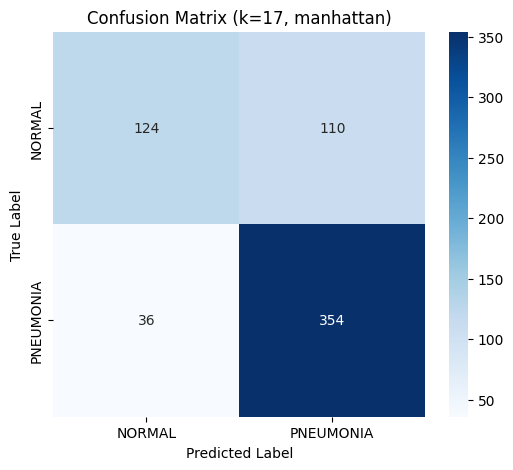

In [32]:
# Standardize features 
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_hist)
test_features = scaler.transform(test_hist)

# Parameters to test
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Best model tracking
best_k = None
best_metric = None
best_score = 0

# Cross-validation loop
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, train_features, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric

print(f" Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%)")

# Train final model with best parameters
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(train_features, labels["train"])

# Evaluate on TEST set
test_predictions = knn.predict(test_features)
test_accuracy = accuracy_score(labels["test"], test_predictions)

print(f"\n Test Accuracy (kNN with {best_metric} distance, k={best_k}): {test_accuracy * 100:.2f}%")
print("\nClassification Report (kNN) on Test Set:")
print(classification_report(labels["test"], test_predictions, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix
cm = confusion_matrix(labels["test"], test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric})")
plt.show()


In [27]:
# Dictionnaires pour stocker les caractéristiques et labels
data_hist = {"train": [], "test": [], "val": []}
labels_hist = {"train": [], "test": [], "val": []}

# Parcourir les dossiers train, test, val
for subdir in ["train", "test", "val"]:
    for category in ["NORMAL", "PNEUMONIA"]:
        folder_path = os.path.join("chest_xray", subdir, category)
        category_label = 0 if category == "NORMAL" else 1

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            
            # Charger l'image en tant que tableau NumPy
            img = imread(file_path)
            
            # Extraire les caractéristiques d'histogramme
            hist_features = extract_histogram_features([img])  # Mettre l'image dans une liste
            
            if hist_features is not None:  # Vérifier si l'extraction a réussi
                data_hist[subdir].append(hist_features[0])  # Extraire l'élément du tableau
                labels_hist[subdir].append(category_label)

# Convertir en numpy arrays
for key in data_hist:
    data_hist[key] = np.array(data_hist[key])
    labels_hist[key] = np.array(labels_hist[key])

print("Extraction des caractéristiques Histogram terminée !")
print(f"Train data shape: {data_hist['train'].shape}, Train labels shape: {labels_hist['train'].shape}")
print(f"Test data shape: {data_hist['test'].shape}, Test labels shape: {labels_hist['test'].shape}")
print(f"Validation data shape: {data_hist['val'].shape}, Validation labels shape: {labels_hist['val'].shape}")

Extraction des caractéristiques Histogram terminée !
Train data shape: (5216, 8), Train labels shape: (5216,)
Test data shape: (624, 8), Test labels shape: (624,)
Validation data shape: (16, 8), Validation labels shape: (16,)


## KNN for Hist

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(data_hist["train"])
X_test = scaler.transform(data_hist["test"])
X_val = scaler.transform(data_hist["val"])
y_train = labels_hist["train"]
y_test = labels_hist["test"]
y_val = labels_hist["val"]

Elbow method

In [29]:
# Parameters to test
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Best model tracking
best_k = None
best_metric = None
best_score = 0

# Cross-validation loop
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X_train, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric

print(f" Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%)")# Initialize and train the kNN classifier

 Best k found: 15 with metric 'manhattan' (CV Accuracy: 86.96%)


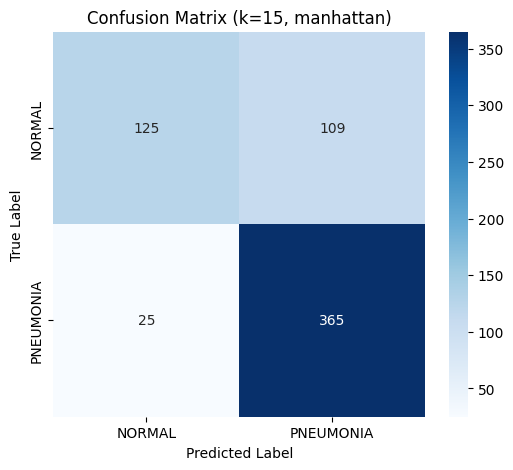


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.83      0.53      0.65       234
   PNEUMONIA       0.77      0.94      0.84       390

    accuracy                           0.79       624
   macro avg       0.80      0.74      0.75       624
weighted avg       0.79      0.79      0.77       624


Accuracy: 78.53%

Validation Accuracy: 50.00%


In [30]:
knn = KNeighborsClassifier(n_neighbors=best_k,metric=best_metric)
knn.fit(X_train, y_train)

# Evaluate on test data
y_pred = knn.predict(X_test)



cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric})")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")
# Prédictions KNN
y_pred_knn_train = knn.predict(X_train)
y_pred_knn_test = knn.predict(X_test)
y_pred_knn_val = knn.predict(X_val)

In [ ]:
print("📌 Accuracy - KNN :")
print(f"Train: {accuracy_score(y_train, y_pred_knn_train):.4f}")
print(f"Test: {accuracy_score(y_test, y_pred_knn_test):.4f}")
print(f"Validation: {accuracy_score(y_val, y_pred_knn_val):.4f}")
print("\n📌 Classification Report - KNN :")
print(classification_report(y_val, y_pred_knn_val, target_names=["NORMAL", "PNEUMONIA"]))

## Naive bayes for Hist

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

# Prédictions Naïve Bayes
y_pred_nb_train = nb.predict(X_train)
y_pred_nb_test = nb.predict(X_test)
y_pred_nb_val = nb.predict(X_val)

In [ ]:
print("\n📌 Accuracy - Naïve Bayes :")
print(f"Train: {accuracy_score(y_train, y_pred_nb_train):.4f}")
print(f"Test: {accuracy_score(y_test, y_pred_nb_test):.4f}")
print(f"Validation: {accuracy_score(y_val, y_pred_nb_val):.4f}")
print("\n📌 Classification Report - Naïve Bayes :")
print(classification_report(y_val, y_pred_nb_val, target_names=["NORMAL", "PNEUMONIA"]))

# 3-First order statistics 

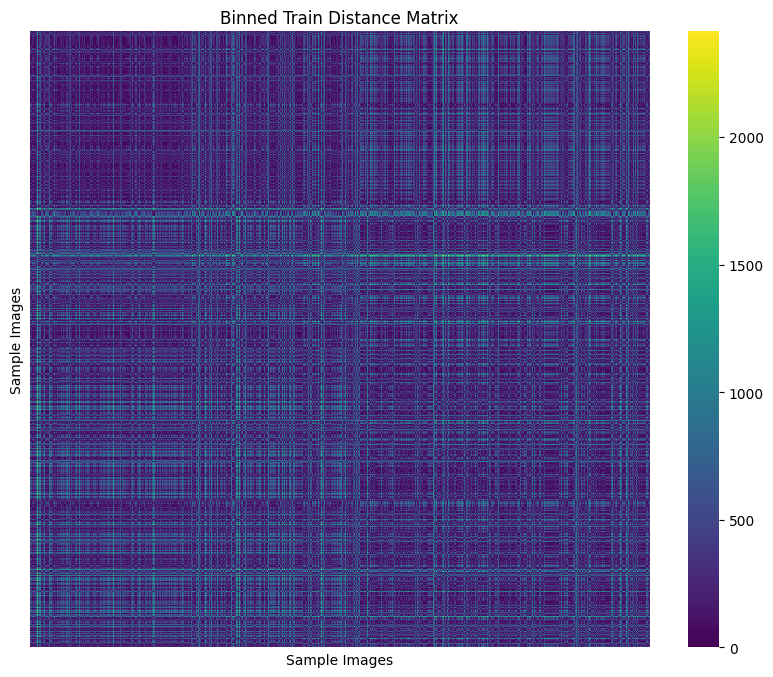

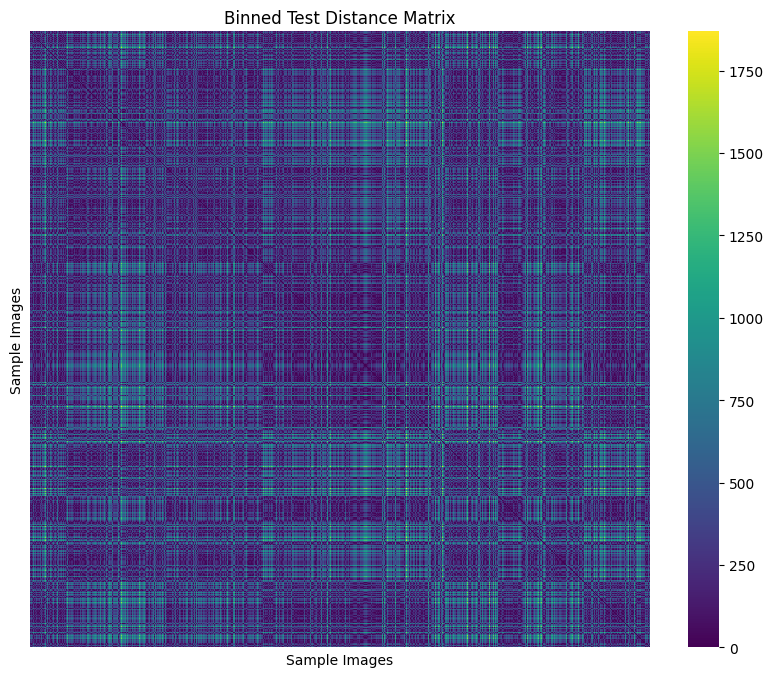

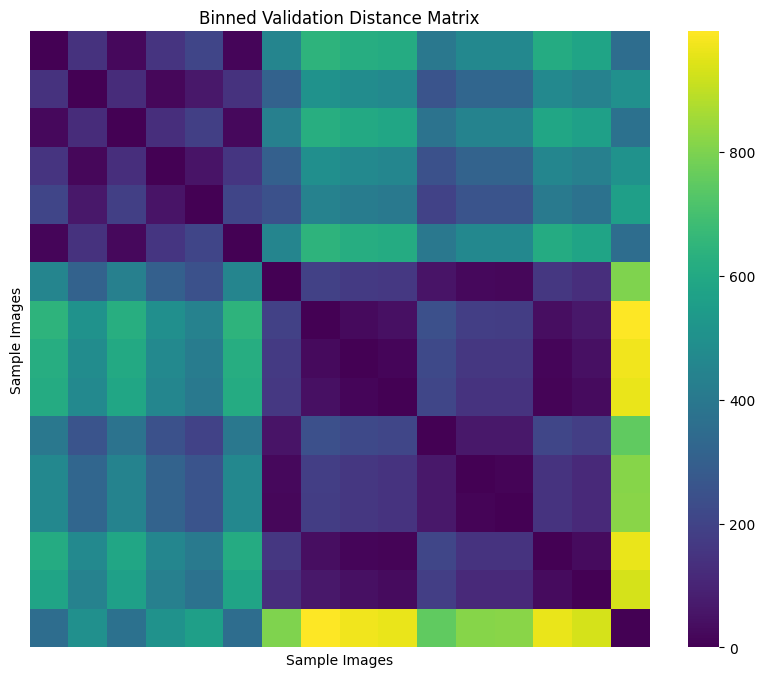

In [43]:
def calculate_first_order_features(image):
    pixels = image.flatten()  # Flatten the 2D array to 1D
    mean = np.mean(pixels)
    variance = np.var(pixels)
    std_dev = np.std(pixels)
    skewness = np.mean(((pixels - mean) / std_dev) ** 3)
    kurtosis = np.mean(((pixels - mean) / std_dev) ** 4) - 3
    min_val = np.min(pixels)
    max_val = np.max(pixels)
    return [mean, variance, std_dev, skewness, kurtosis, min_val, max_val]

# Function to load images from a specific folder
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize to 128x128
            images.append(np.array(img))  # Convert to numpy array
            labels.append(label)  # Append the label
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return images, labels

# Function to compute the pairwise distance matrix
def compute_distance_matrix(features):
    """
    Compute the pairwise distance matrix for the given features.
    """
    distances = squareform(pdist(features, metric='euclidean'))  # Use Euclidean distance
    return distances

# Function to plot the distance matrix
def plot_distance_matrix(distance_matrix, title):
    """
    Plot the distance matrix as a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, cmap='viridis', annot=False, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Sample Images")
    plt.ylabel("Sample Images")
    plt.show()

# Function to apply binning to feature vectors
def apply_binning(features, n_bins=3):
    """
    Apply binning to reduce the size of the feature vectors.
    """
    binned_features = []
    for feature_vector in features:
        # Split the feature vector into `n_bins` and compute the mean of each bin
        binned_vector = np.array_split(feature_vector, n_bins)
        binned_vector = [np.mean(bin) for bin in binned_vector]
        binned_features.append(binned_vector)
    return np.array(binned_features)

# Dataset path
dataset_path = "chest_xray"
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

# Load images and compute first-order statistics
features = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, _ = load_images_from_folder(folder_path, category_label)
        for img in images:
            feature_vector = calculate_first_order_features(img)
            features[subdir].append(feature_vector)

# Apply binning to reduce the size of the feature vectors
n_bins = 3  # Number of bins
features["train"] = apply_binning(features["train"], n_bins=n_bins)
features["test"] = apply_binning(features["test"], n_bins=n_bins)
features["val"] = apply_binning(features["val"], n_bins=n_bins)

# Convert to numpy arrays
features["train"] = np.array(features["train"])
features["test"] = np.array(features["test"])
features["val"] = np.array(features["val"])

# Compute and visualize the distance matrix for all train images
train_distance_matrix = compute_distance_matrix(features["train"])
plot_distance_matrix(train_distance_matrix, "Binned Train Distance Matrix")

# Compute and visualize the distance matrix for all test images
test_distance_matrix = compute_distance_matrix(features["test"])
plot_distance_matrix(test_distance_matrix, "Binned Test Distance Matrix")

# Compute and visualize the distance matrix for all validation images
val_distance_matrix = compute_distance_matrix(features["val"])
plot_distance_matrix(val_distance_matrix, "Binned Validation Distance Matrix")

## KNN with first order feature

In [44]:
# Combine data and labels
X_train = features["train"]
y_train = labels["train"]  # Corresponding labels for train
X_val = features["val"]
y_val = labels["val"]  # Corresponding labels for val
X_test = features["test"]
y_test = labels["test"]  # Corresponding labels for test

# Flatten data to 2D arrays if needed (for sklearn compatibility)
X_train = np.array([x.flatten() for x in X_train])
X_val = np.array([x.flatten() for x in X_val])
X_test = np.array([x.flatten() for x in X_test])

# Combine train and validation sets for training the final model (optional)
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))


In [46]:
# Parameters to test
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Best model tracking
best_k = None
best_metric = None
best_score = 0

# Cross-validation loop
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X_train, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric

print(f" Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%)")


 Best k found: 19 with metric 'manhattan' (CV Accuracy: 82.11%)


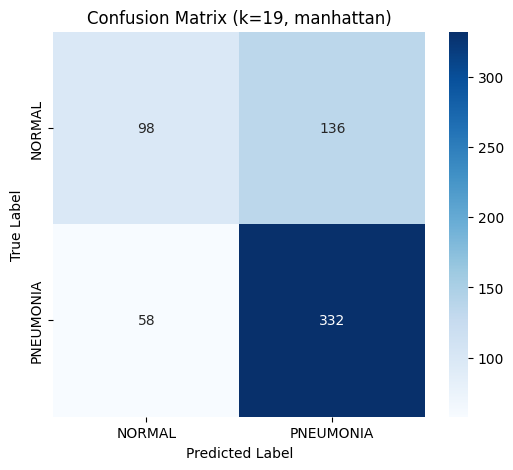


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.63      0.42      0.50       234
   PNEUMONIA       0.71      0.85      0.77       390

    accuracy                           0.69       624
   macro avg       0.67      0.64      0.64       624
weighted avg       0.68      0.69      0.67       624


Accuracy: 68.91%

Validation Accuracy: 68.75%


In [47]:
# Initialize and train the kNN classifier
knn = KNeighborsClassifier(n_neighbors=best_k,metric=best_metric)
knn.fit(X_train, y_train)

# Evaluate on test data
y_pred = knn.predict(X_test)



cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric})")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")


## Naive bayes with first order feature

In [ ]:
# Initialize and train the Naïve Bayes classifier
nb = GaussianNB()
nb.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = nb.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = nb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

# 4-GLCM

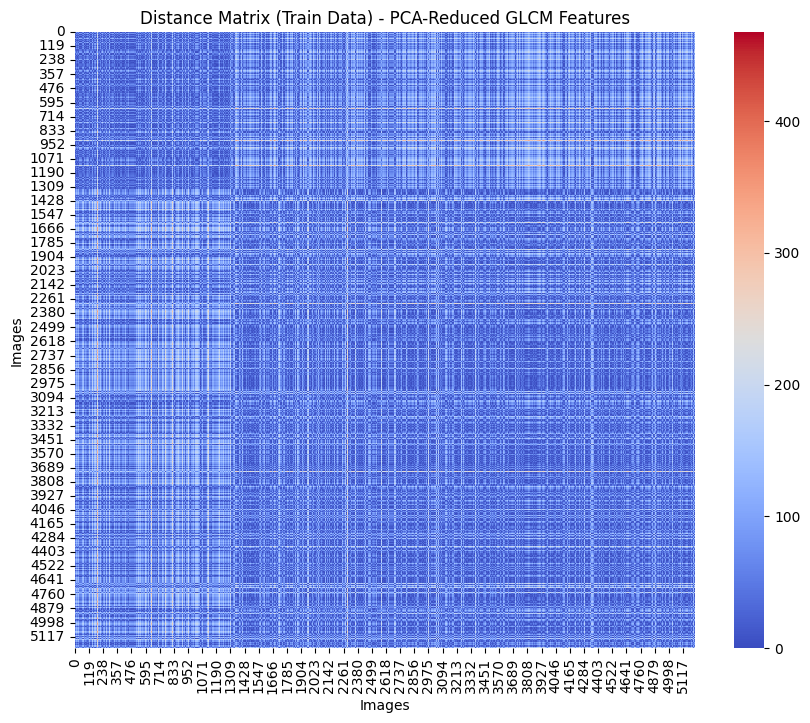

In [54]:
def calculate_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    # Compute GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    # Extract features
    contrast = graycoprops(glcm, 'contrast').mean()  # Mean over all distances and angles
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    
    return [contrast, correlation, energy, homogeneity]

# Dataset path
dataset_path = "chest_xray"

# Define subdirectories and categories
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

# Function to load images from a specific folder
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Open the image
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize to 128x128
            images.append(np.array(img))  # Convert to numpy array
            labels.append(label)  # Append the label
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return images, labels

# Load images and calculate GLCM features
glcm_features = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, _ = load_images_from_folder(folder_path, category_label)
        # Compute GLCM features for each image
        for img in images:
            features = calculate_glcm_features(img)
            glcm_features[subdir].append(features)

# Convert to numpy arrays
glcm_features["train"] = np.array(glcm_features["train"])
glcm_features["test"] = np.array(glcm_features["test"])
glcm_features["val"] = np.array(glcm_features["val"])

# Apply PCA to reduce the dimensionality of the features
pca = PCA(n_components=2)  # Reduce to 2 components
glcm_features["train"] = pca.fit_transform(glcm_features["train"])
glcm_features["test"] = pca.transform(glcm_features["test"])
glcm_features["val"] = pca.transform(glcm_features["val"])

# Example: Compute and visualize the distance matrix for train GLCM features
distance_matrix = cdist(glcm_features["train"], glcm_features["train"], metric="euclidean")

# Plot the heatmap of the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap="coolwarm", cbar=True)
plt.title("Distance Matrix (Train Data) - PCA-Reduced GLCM Features")
plt.xlabel("Images")
plt.ylabel("Images")
plt.show()

## KNN with glcm

In [56]:
# Combine data and labels
X_train = glcm_features["train"]
y_train = labels["train"]  # Corresponding labels for train
X_val = glcm_features["val"]
y_val = labels["val"]  # Corresponding labels for val
X_test = glcm_features["test"]
y_test = labels["test"]  # Corresponding labels for test

# Flatten data to 2D arrays if needed (for sklearn compatibility)
X_train = np.array([x.flatten() for x in X_train])
X_val = np.array([x.flatten() for x in X_val])
X_test = np.array([x.flatten() for x in X_test])

# Combine train and validation sets for training the final model (optional)
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))


In [57]:
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Best model tracking
best_k = None
best_metric = None
best_score = 0

# Cross-validation loop
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X_train, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric

print(f" Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%)")

 Best k found: 17 with metric 'chebyshev' (CV Accuracy: 77.45%)


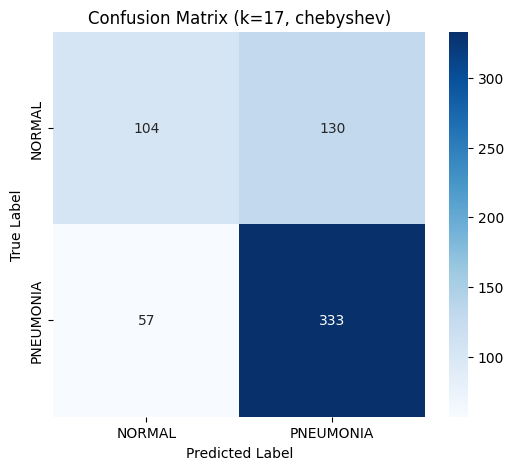


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.65      0.44      0.53       234
   PNEUMONIA       0.72      0.85      0.78       390

    accuracy                           0.70       624
   macro avg       0.68      0.65      0.65       624
weighted avg       0.69      0.70      0.69       624


Accuracy: 70.03%

Validation Accuracy: 62.50%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.65      0.44      0.53       234
   PNEUMONIA       0.72      0.85      0.78       390

    accuracy                           0.70       624
   macro avg       0.68      0.65      0.65       624
weighted avg       0.69      0.70      0.69       624


Accuracy: 70.03%

Validation Accuracy: 62.50%


In [58]:
# Initialize and train the kNN classifier
knn = KNeighborsClassifier(n_neighbors=best_k,metric=best_metric)
knn.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = knn.predict(X_test)



cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric})")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

## Naive bayes with glcm

In [ ]:
# Initialize and train the Naïve Bayes classifier
nb = GaussianNB()
nb.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = nb.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = nb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

# 5-Filtre de gabor

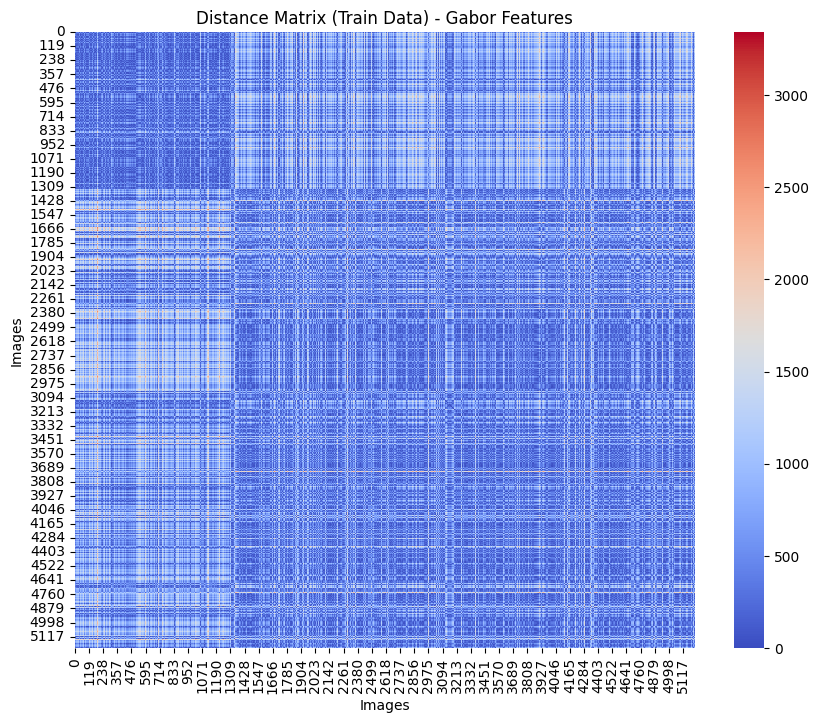

In [59]:

def apply_gabor_filter(image, kernel_size=31, frequencies=[0.2, 0.4], thetas=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    features = []
    for freq in frequencies:
        for theta in thetas:
            # Create Gabor kernel
            kernel = cv2.getGaborKernel((kernel_size, kernel_size), 4.0, theta, 1.0 / freq, 0.5, 0, ktype=cv2.CV_32F)
            
            # Apply Gabor filter
            filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            
            # Extract features from the filtered image
            mean = np.mean(filtered)
            variance = np.var(filtered)
            features.extend([mean, variance])  # Add mean and variance to the feature vector
    
    # Aggregate features (e.g., compute global mean and variance)
    aggregated_features = [np.mean(features), np.std(features)]
    return aggregated_features

# Dataset path
dataset_path = "chest_xray"

# Define subdirectories and categories
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

# Function to load images from a specific folder
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Open the image
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize to 128x128
            images.append(np.array(img))  # Convert to numpy array
            labels.append(label)  # Append the label
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return images, labels

# Load images and calculate Gabor filter features
data = {"train": [], "test": [], "val": []}
gabor_features = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, _ = load_images_from_folder(folder_path, category_label)
        # Compute Gabor filter features for each image
        for img in images:
            features = apply_gabor_filter(img)
            gabor_features[subdir].append(features)

# Convert to numpy arrays
gabor_features["train"] = np.array(gabor_features["train"])
gabor_features["test"] = np.array(gabor_features["test"])
gabor_features["val"] = np.array(gabor_features["val"])

# Example: Compute and visualize the distance matrix for train Gabor features
distance_matrix = cdist(gabor_features["train"], gabor_features["train"], metric="euclidean")

# Plot the heatmap of the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap="coolwarm", cbar=True)
plt.title("Distance Matrix (Train Data) - Gabor Features")
plt.xlabel("Images")
plt.ylabel("Images")
plt.show()


## KNN with Gabor feature

In [60]:
# Combine data and labels
X_train = gabor_features["train"]
y_train = labels["train"]  # Corresponding labels for train
X_val = gabor_features["val"]
y_val = labels["val"]  # Corresponding labels for val
X_test = gabor_features["test"]
y_test = labels["test"]  # Corresponding labels for test

# Flatten data to 2D arrays if needed (for sklearn compatibility)
X_train = np.array([x.flatten() for x in X_train])
X_val = np.array([x.flatten() for x in X_val])
X_test = np.array([x.flatten() for x in X_test])

# Combine train and validation sets for training the final model (optional)
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))


In [61]:
# Parameters to test
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Best model tracking
best_k = None
best_metric = None
best_score = 0

# Cross-validation loop
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X_train, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric

print(f" Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%)")

 Best k found: 19 with metric 'manhattan' (CV Accuracy: 84.55%)


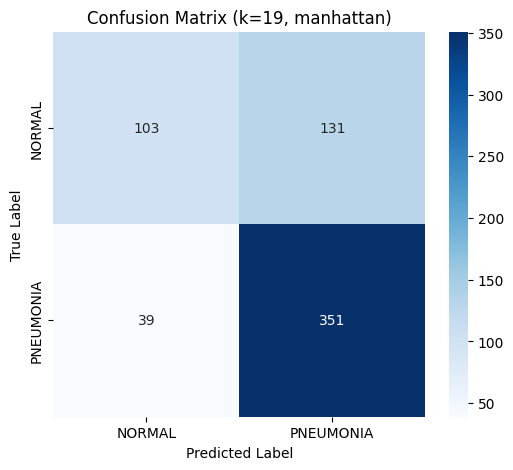


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.73      0.44      0.55       234
   PNEUMONIA       0.73      0.90      0.81       390

    accuracy                           0.73       624
   macro avg       0.73      0.67      0.68       624
weighted avg       0.73      0.73      0.71       624


Accuracy: 72.76%

Validation Accuracy: 62.50%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.73      0.44      0.55       234
   PNEUMONIA       0.73      0.90      0.81       390

    accuracy                           0.73       624
   macro avg       0.73      0.67      0.68       624
weighted avg       0.73      0.73      0.71       624


Accuracy: 72.76%

Validation Accuracy: 62.50%


In [62]:
# Initialize and train the kNN classifier
knn = KNeighborsClassifier(n_neighbors=best_k,metric=best_metric)
knn.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = knn.predict(X_test)



cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric})")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

## Naive bayes with gabor feature

In [ ]:
# Initialize and train the Naïve Bayes classifier
nb = GaussianNB()
nb.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = nb.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = nb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

# 6-LBP feature

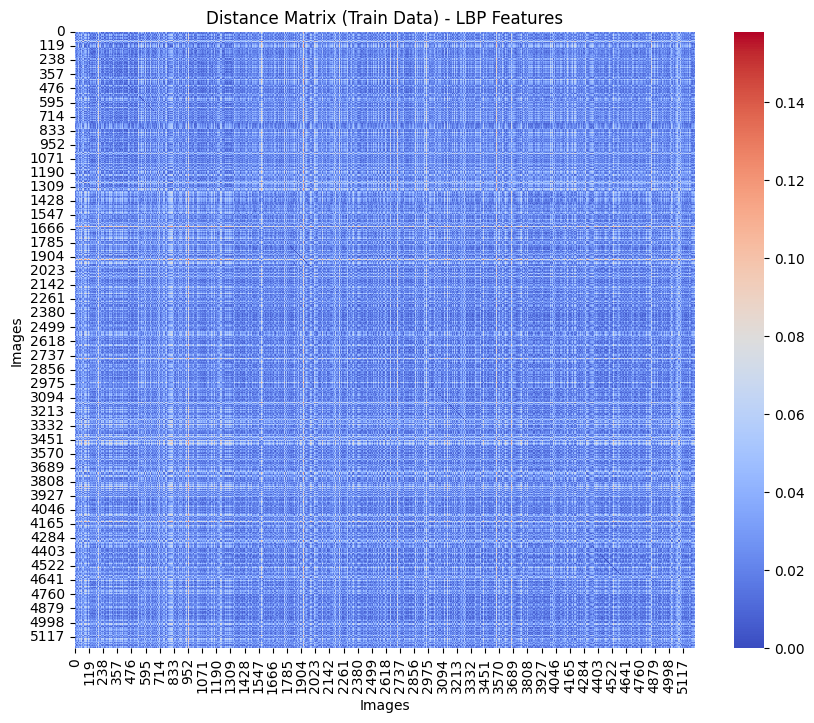

In [63]:

# Function to compute LBP features
def calculate_lbp_features(image, P=8, R=1):
    # Compute LBP
    lbp = local_binary_pattern(image, P=P, R=R, method="uniform")
    # Compute histogram of LBP
    n_bins = P + 2  # Uniform patterns + 1 for others
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    # Normalize histogram
    hist = hist / hist.sum()
    # Select the most important features (e.g., the first 5 bins)
    selected_features = hist[:5]
    return selected_features

# Dataset path
dataset_path = "chest_xray"

# Define subdirectories and categories
subdirs = ["train", "test", "val"]
categories = ["NORMAL", "PNEUMONIA"]

# Function to load images from a specific folder
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Open the image
            img = Image.open(file_path).convert("L")  # Convert to grayscale
            img = img.resize((128, 128))  # Resize to 128x128
            images.append(np.array(img))  # Convert to numpy array
            labels.append(label)  # Append the label
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return images, labels

# Load images and calculate LBP features
data = {"train": [], "test": [], "val": []}
lbp_features = {"train": [], "test": [], "val": []}

for subdir in subdirs:
    for category in categories:
        folder_path = os.path.join(dataset_path, subdir, category)
        category_label = 0 if category == "NORMAL" else 1
        images, _ = load_images_from_folder(folder_path, category_label)
        # Compute LBP features for each image
        for img in images:
            features = calculate_lbp_features(img)
            lbp_features[subdir].append(features)

# Convert to numpy arrays
lbp_features["train"] = np.array(lbp_features["train"])
lbp_features["test"] = np.array(lbp_features["test"])
lbp_features["val"] = np.array(lbp_features["val"])

# Example: Compute and visualize the distance matrix for train LBP features
distance_matrix = cdist(lbp_features["train"], lbp_features["train"], metric="euclidean")

# Plot the heatmap of the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap="coolwarm", cbar=True)
plt.title("Distance Matrix (Train Data) - LBP Features")
plt.xlabel("Images")
plt.ylabel("Images")
plt.show()


## KNN with LBP feature

In [64]:
# Combine data and labels
X_train = lbp_features["train"]
y_train = labels["train"]  # Corresponding labels for train
X_val = lbp_features["val"]
y_val = labels["val"]  # Corresponding labels for val
X_test = lbp_features["test"]
y_test = labels["test"]  # Corresponding labels for test

# Flatten data to 2D arrays if needed (for sklearn compatibility)
X_train = np.array([x.flatten() for x in X_train])
X_val = np.array([x.flatten() for x in X_val])
X_test = np.array([x.flatten() for x in X_test])

# Combine train and validation sets for training the final model (optional)
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))



In [65]:
# Parameters to test
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Best model tracking
best_k = None
best_metric = None
best_score = 0

# Cross-validation loop
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X_train, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric

print(f" Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%)")

 Best k found: 11 with metric 'manhattan' (CV Accuracy: 85.12%)


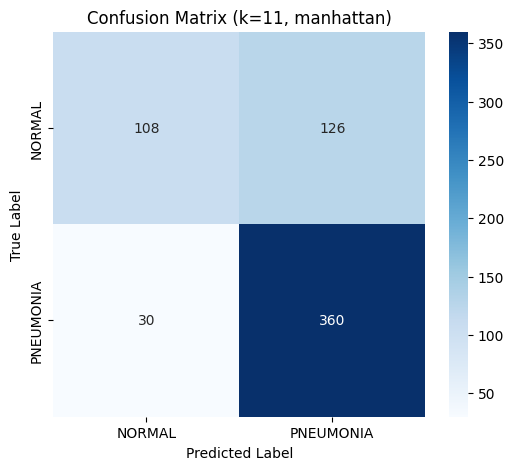


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.78      0.46      0.58       234
   PNEUMONIA       0.74      0.92      0.82       390

    accuracy                           0.75       624
   macro avg       0.76      0.69      0.70       624
weighted avg       0.76      0.75      0.73       624


Accuracy: 75.00%

Validation Accuracy: 62.50%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.78      0.46      0.58       234
   PNEUMONIA       0.74      0.92      0.82       390

    accuracy                           0.75       624
   macro avg       0.76      0.69      0.70       624
weighted avg       0.76      0.75      0.73       624


Accuracy: 75.00%

Validation Accuracy: 62.50%


In [66]:
# Initialize and train the kNN classifier
knn = KNeighborsClassifier(n_neighbors=best_k,metric=best_metric)
knn.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = knn.predict(X_test)



cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric})")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")


## Naive bayes with LBP feature

In [ ]:
# Initialize and train the Naïve Bayes classifier
nb = GaussianNB()
nb.fit(X_combined, y_combined)

# Evaluate on test data
y_pred = nb.predict(X_test)

# Performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = nb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

# Combained features

In [69]:
combined_features = {}
for subdir in subdirs:
    combined_features[subdir] = np.concatenate((data_hist[subdir], lbp_features[subdir], glcm_features[subdir], gabor_features[subdir]), axis=1)

# Normalisation des données combinées
scaler = StandardScaler()
X_train = scaler.fit_transform(combined_features["train"])
X_test = scaler.transform(combined_features["test"])
X_val = scaler.transform(combined_features["val"])
y_train = labels_hist["train"]  # Utilisez les labels des histogrammes (identiques pour LBP)
y_test = labels_hist["test"]
y_val = labels_hist["val"]


In [ ]:
# Parameters to test
k_values = range(1, 20, 2)  # Testing odd values from 1 to 19
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

# Best model tracking
best_k = None
best_metric = None
best_score = 0

# Cross-validation loop
cv = StratifiedKFold(n_splits=5)  # Ensures balanced classes in folds
for metric in distance_metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X_train, labels["train"], cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_metric = metric

print(f" Best k found: {best_k} with metric '{best_metric}' (CV Accuracy: {best_score * 100:.2f}%)")

In [ ]:
# Initialize and train the kNN classifier
knn = KNeighborsClassifier(n_neighbors=best_k,metric=best_metric)
knn.fit(X_train, y_train)

# Evaluate on test data
y_pred = knn.predict(X_test)



cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (k={best_k}, {best_metric})")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Optional: Evaluate on validation set separately (if not combined earlier)
y_val_pred = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

# Model VIT

In [3]:

# Charger le processeur d'images
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# Charger le modèle ViT pré-entraîné
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Transformations des images
transform = transforms.Compose([
    transforms.Grayscale(),  # Convertir en niveaux de gris
    transforms.Resize((128, 128)),  # Redimensionner
    transforms.ToTensor(),  # Convertir en tenseur PyTorch
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalisation
])

# Charger le dataset avec ImageFolder
train_dataset = datasets.ImageFolder(root="chest_xray/train", transform=transform)
val_dataset = datasets.ImageFolder(root="chest_xray/test", transform=transform)

# Utiliser un DataLoader pour charger par batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [11]:

# Charger le modèle pré-entraîné ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modifier la première couche (car images en niveaux de gris, pas RGB)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modifier la dernière couche pour correspondre à 2 classes (Normal/Pneumonia)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes

# Envoyer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Envoyer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Mode entraînement
        running_loss = 0.0
        correct = 0
        total = 0

        # Boucle sur les batches d'entraînement
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Réinitialiser les gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Mise à jour des poids

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Époque {epoch+1}, Perte : {running_loss:.4f}, Exactitude : {train_acc:.2f}%")

        # Validation après chaque époque
        validate_model(model, val_loader, criterion)

def validate_model(model, val_loader, criterion):
    model.eval()  # Mode évaluation
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Validation - Perte : {val_loss:.4f}, Exactitude : {val_acc:.2f}%")


In [ ]:
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


In [14]:

def predict_image(model, image_path):
    model.eval()
    
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Ajouter une dimension batch

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_names = ["NORMAL", "PNEUMONIA"]
    return class_names[predicted.item()]

image_path = "chest_xray/test/PNEUMONIA/person78_bacteria_378.jpeg"
prediction = predict_image(model, image_path)
print(f"Prédiction : {prediction}")


Prédiction : PNEUMONIA


In [17]:

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=["NORMAL", "PNEUMONIA"]))

# Évaluer le modèle sur le set de test
evaluate_model(model, val_loader)


              precision    recall  f1-score   support

      NORMAL       0.97      0.49      0.65       234
   PNEUMONIA       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.75       624
weighted avg       0.84      0.80      0.78       624



🔍 Analyse des résultats

✅ Accuracy = 94% → Très bon score, mais il faut vérifier si le modèle est équilibré.

✅ Precision & Recall élevés → Le modèle généralise bien et fait peu d'erreurs.

✅ F1-score ≈ 0.94 → Bon équilibre entre précision et rappel.

📌 Détails par classe :

NORMAL (Précision = 1.00, Rappel = 0.88)

✅ Aucun faux positif (précision parfaite).

❌ Mais il manque 12% des vrais cas normaux (faux négatifs).

PNEUMONIA (Précision = 0.89, Rappel = 1.00)

❌ 11% de faux positifs (précision < 1).

✅ Aucun cas de pneumonie raté (rappel parfait).

In [16]:
# Sauvegarder le modèle
#torch.save(model.state_dict(), "model_cnn.pth")

# Charger le modèle
model.load_state_dict(torch.load("model_cnn.pth"))
model.to(device)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Handling Data imbalance 

In [23]:
total_samples = COUNT_NORMAL['train'] + COUNT_PNEUMONIA['train']

# Calculate class weights (inverse frequency of each class)
weight_normal = total_samples / COUNT_NORMAL['train']
weight_pneumonia = total_samples / COUNT_PNEUMONIA['train']

# Create the class weights tensor
class_weights = torch.tensor([weight_normal, weight_pneumonia]).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [26]:
# Define optimizer (if needed)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (same as before)
for epoch in range(10):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Use the class-weighted loss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{10}], Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")


Epoch [1/10], Loss: 6.1056, Accuracy: 98.72%
Epoch [2/10], Loss: 5.3790, Accuracy: 98.73%
Epoch [3/10], Loss: 3.4397, Accuracy: 99.35%
Epoch [4/10], Loss: 6.6583, Accuracy: 98.66%
Epoch [5/10], Loss: 2.2204, Accuracy: 99.60%
Epoch [6/10], Loss: 1.9625, Accuracy: 99.58%
Epoch [7/10], Loss: 2.9753, Accuracy: 99.54%
Epoch [8/10], Loss: 2.1518, Accuracy: 99.60%
Epoch [9/10], Loss: 3.1067, Accuracy: 99.44%
Epoch [10/10], Loss: 2.1344, Accuracy: 99.52%


In [27]:
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    val_acc = 100 * correct / total

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["NORMAL", "PNEUMONIA"]))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

# Call the evaluation function
evaluate_model(model, val_loader)


Validation Loss: 23.2662, Accuracy: 84.29%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.61      0.74       234
   PNEUMONIA       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624


Confusion Matrix:
[[143  91]
 [  7 383]]


Validation Loss: 23.2662, Accuracy: 84.29%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.61      0.74       234
   PNEUMONIA       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624


Confusion Matrix:
[[143  91]
 [  7 383]]


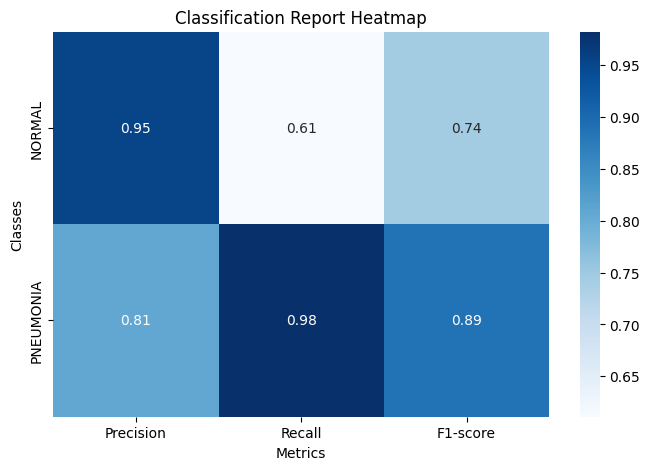

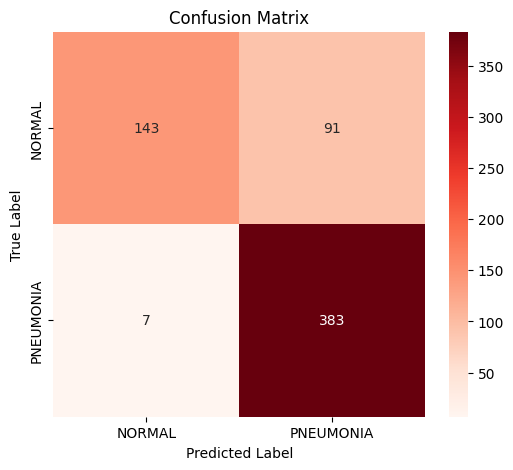

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_classification_report(y_true, y_pred, class_names):
    """Plot classification report as a heatmap."""
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_matrix = np.array([[report[label][metric] for metric in ["precision", "recall", "f1-score"]] for label in class_names])

    plt.figure(figsize=(8, 5))
    sns.heatmap(report_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Precision", "Recall", "F1-score"], yticklabels=class_names)
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.title("Classification Report Heatmap")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix as a heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    val_acc = 100 * correct / total

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    class_names = ["NORMAL", "PNEUMONIA"]
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Generate plots
    plot_classification_report(all_labels, all_preds, class_names)
    plot_confusion_matrix(all_labels, all_preds, class_names)

# Call the evaluation function
evaluate_model(model, val_loader)


In [29]:
torch.save(model.state_dict(), "model_cnn.pth")

# Data augmentation

In [ ]:

# Get class distribution in training set
train_classes = [label for _, label in train_dataset]
class_counts = Counter(train_classes)

print("Class Distribution in Training Set:", train_dataset.class_to_idx)
print("Class Counts:", class_counts)


In [ ]:
# Define augmentations (apply only to minority class)
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, minority_class, augment_factor=2):
        self.dataset = dataset
        self.minority_class = minority_class
        self.augment_factor = augment_factor  # Number of extra augmented copies
        
        # Split dataset into majority and minority samples
        self.minority_samples = [sample for sample in dataset if sample[1] == minority_class]
        self.majority_samples = [sample for sample in dataset if sample[1] != minority_class]

        # Augment minority class
        self.augmented_samples = []
        for img_tensor, label in self.minority_samples:
            img_pil = F.to_pil_image(img_tensor)  # Convert tensor to PIL image
            for _ in range(augment_factor):
                aug_img = augment_transform(img_pil)  # Apply augmentation
                self.augmented_samples.append((aug_img, label))

        # Combine original and augmented data
        self.new_data = self.majority_samples + self.minority_samples + self.augmented_samples

    def __len__(self):
        return len(self.new_data)

    def __getitem__(self, idx):
        return self.new_data[idx]

# Find the minority class
minority_class = min(class_counts, key=class_counts.get)

# Apply augmentation
augmented_train_dataset = AugmentedDataset(train_dataset, minority_class, augment_factor=3)

# Use the new dataset in DataLoader
train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)


In [ ]:
# Train the model with augmented dataset
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
# Evaluate the model after training
evaluate_model(model, val_loader)
